# Initialize


In [1]:
expt_path = 'C:\\_Data\\QB-CB7\\'
cfg_file='QB-CB7.yml'
ip = '10.108.30.23'
max_t1 = 300

## Set up new config 
Set to variables to True when setting up a new experiment. 

Note: make sure you set your ADC/DAC channels correctly. This code does not automatically fill in the ADC/DAC into your configuration file, so you should check yourself to make sure these values are correct. 

There are several elements that you may want to customize based on your readout parameters and coherence times. Check readme file config_init_config_manual.md

In [2]:
import os
import sys 
sys.path.append('../')
import slab_qick_calib.config as config

# Set to false if you aren't creating a new one
new_config = False
new_folder = False

configs_dir = os.path.join(os.getcwd(), 'configs')
cfg_file_path = os.path.join(configs_dir, cfg_file)
images_dir = os.path.join(expt_path, 'images')
summary_dir = os.path.join(images_dir, 'summary')

if new_config or new_folder:
    nqubits = 3
    rfsoc_alias = 'bf1_soc'
    t1_guess = 30 

    if new_config:
        config.init_config(cfg_file_path, nqubits, type='full', aliases=rfsoc_alias, t1=t1_guess)

    if not os.path.exists(expt_path):
        os.makedirs(expt_path)
        os.mkdir(images_dir)
        os.mkdir(summary_dir)

print('Data will be stored in', expt_path)

Data will be stored in C:\_Data\QB-CB7\


## Connect to RFSoC
Before running first cell, make sure a nameserver is running on the network, the Qick board is connected to it, and the ip address listed below matches that of the nameserver. 

You just need to run the first cell, then should be able to run any other cell in whatever order. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qick import QickConfig
import sys 
sys.path.append('../')
from slab_qick_calib.exp_handling.instrumentmanager import InstrumentManager
import slab_qick_calib.experiments as meas
from slab_qick_calib.calib import qubit_tuning, tuneup
from slab_qick_calib import handy
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

# Set color palette and font size
handy.config_figs()

# Results config file
cfg_path = os.path.join(os.getcwd(), 'configs', cfg_file)
auto_cfg = config.load(cfg_path)

# Connect to instruments
im = InstrumentManager(ns_address=ip)
print(im)
soc = QickConfig(im[auto_cfg['aliases']['soc']].get_cfg())
print(soc)

cfg_dict = {'soc': soc, 'expt_path': expt_path, 'cfg_file': cfg_path, 'im': im}

imported experiments.single_qubit.active_reset
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.rabi
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.single_shot_opt
imported experiments.single_qubit.stark_spectroscopy
imported experiments.single_qubit.t1
imported experiments.single_qubit.t1_cont
imported experiments.single_qubit.t1_stark
imported experiments.single_qubit.t2
imported experiments.single_qubit.t2_ramsey_stark
imported experiments.single_qubit.tof_calibration
imported experiments.two_qubit.rabi_2q
imported experiments.two_qubit.t1_2q
imported experiments.two_qubit.t1_2q_cont
imported experiments.two_qubit.t1_2q_conttest
imported experiments.single_qubit.active_reset
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.rabi
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.sin

## How to update config (you can also just edit yml directly)

In [ ]:
# #                                          param   value                        qubit #
# auto_cfg = config.update_readout(cfg_path, 'lamb', 5, qi)
# auto_cfg = config.update_qubit(cfg_path, 'f_ge', 5700, qi)

# # For multiple levels of nesting: 
# auto_cfg = config.update_qubit(cfg_path, ('pulses','pi_ge','gain'), 0.2, qi)


In general, all scans will be interacted with either by running default, or giving arguments from params dict. 
You can run scans on list of different qubits or just one by adding first couple lines of each cell. 
Flag of update is used to decide if to set new config vals based on output of scan (if the fit looks good)

## Check QICK issues

### Check mirror frequencies on qubit

In [274]:
import qick_check
qick_check.check_freqs(1, cfg_dict)

Nyquist frequency: 4792.32 MHz
Possible g-e frequencies: 5506.532 MHz and 4078.1079999999993 MHz
Possible e-f frequencies: 5349.729 MHz and 4234.910999999999 MHz
Anharmonicity: 156.80299999999988 MHz. With aliased e-f: 1271.621000000001 MHz
Both e-f frequencies are less than the chosen g-e frequency and greater than the aliased g-e frequency.
Recommendation: Current g-e frequency is the correct choice.


### Check mirror frequencies from resonators

In [20]:
import qick_check

qick_check.check_resonances(cfg_dict)

Nyquist frequency: 4792.32 MHz
Configured resonator frequencies (MHz):
[5379.1363 5923.5372 6626.4125]
Aliased resonator frequencies (MHz):
[4205.5037 3661.1028 2958.2275]


### Check sampling rates and minimum point spacing

In [ ]:
cfg_dict['soc']._get_ch_cfg(ro_ch=0)['f_dds']/2
cfg_dict['soc'].cycles2us(1)

### Make sure you're not near the nyquist frequency of the ADC

In [ ]:
import qick_check
qick_check.check_adc(cfg_dict)

# Time of Flight (TOF)

TOF measures the time it takes for the signal to run through the wires. It will give us the time in clock ticks that we should wait to make a measurements 

 Use this to set trig_offset in config file

  0%|          | 0/1000 [00:00<?, ?it/s]

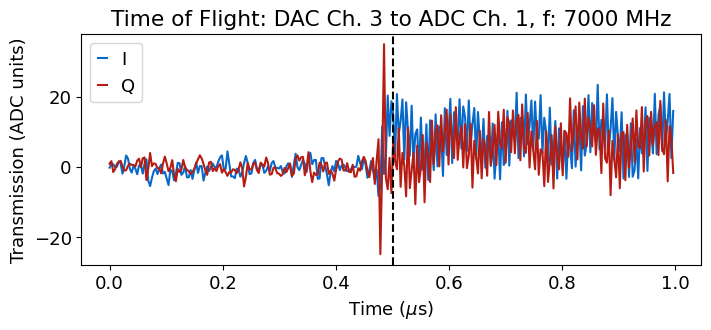

  0%|          | 0/1000 [00:00<?, ?it/s]

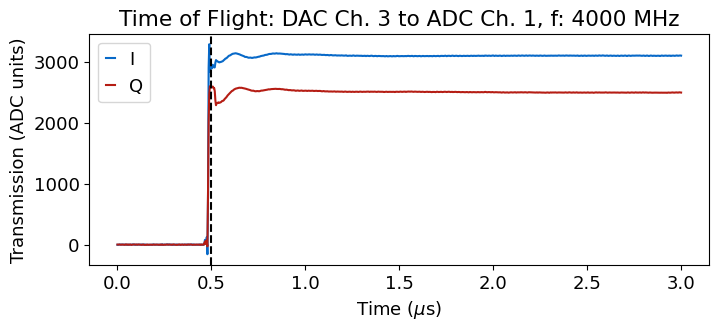

In [ ]:
qubit_list = np.arange(3)
qubit_list = [0]
for qi in qubit_list:  
        #tof=meas.ToFCalibrationExperiment(cfg_dict=cfg_dict, qi=qi)

        # Set frequency of choice and readout length up to 13 us
        tof=meas.ToFCalibrationExperiment(cfg_dict=cfg_dict, qi=qi,params={'readout_length':3,'frequency':4000})
       

# Resonator Spectroscopy 

Run resonator spectroscopy for all resonators by choosing a large frequency scan to look over. The scan will then find the different resonators and fill in the config file with their respective frequencies. In the autocalibration, there will be a finer sweep of each resonator to more accurately find its frequency. The frequencies are saved in <code>auto_cfg.device.readout.frequency</code>

## Coarse 

This will perform peak finding

  0%|          | 0/3600000 [00:00<?, ?it/s]

Number of peaks: 0


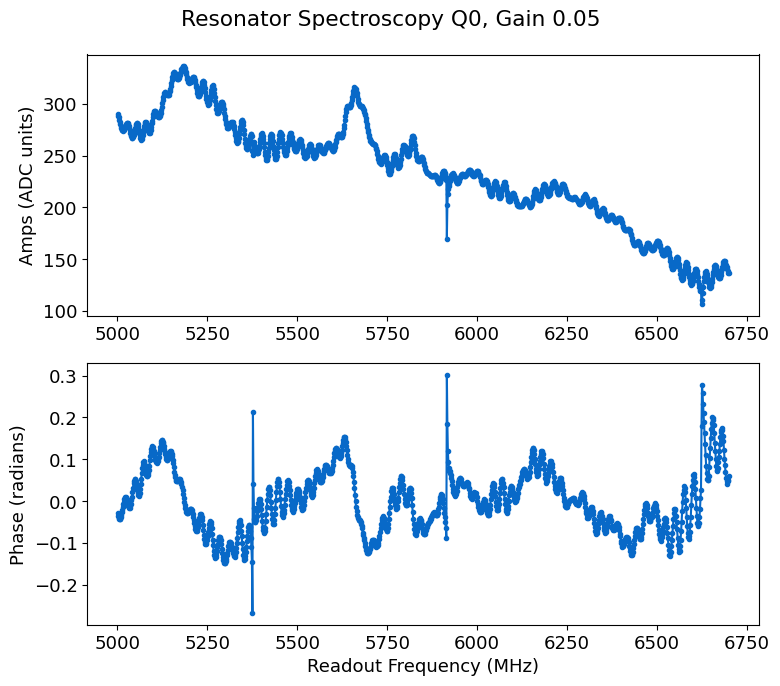

In [9]:
#rspec = cfg.make_rspec_coarse(soc, expt_path, cfg_path, i, im=im, start=6000, span=800, reps=2000, npts=5000)
qi=0
rspecc = meas.ResSpec(cfg_dict, qi=qi, style='coarse', params={'start':5000, 'span':1700, 'soft_avgs':1, 'reps':3000, 'gain':0.05, 'expts':1200})
res_values = rspecc.data['coarse_peaks']

Change prom (prominence value) to adjust how to find the peaks

Number of peaks: 3


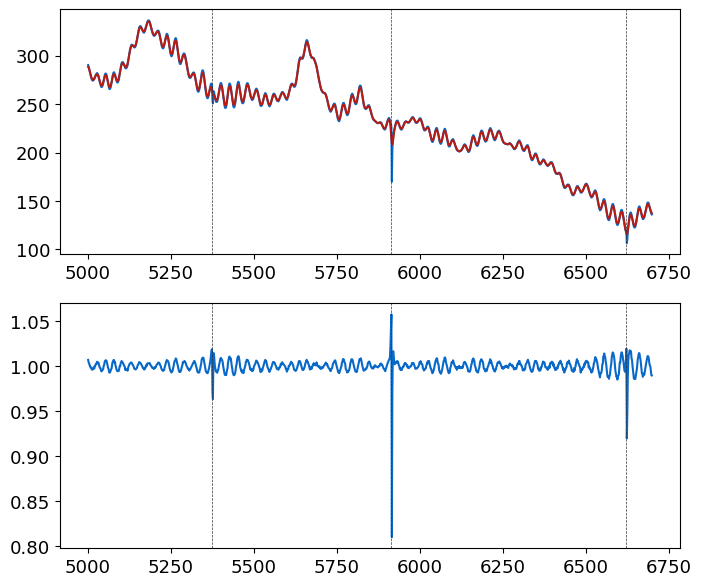

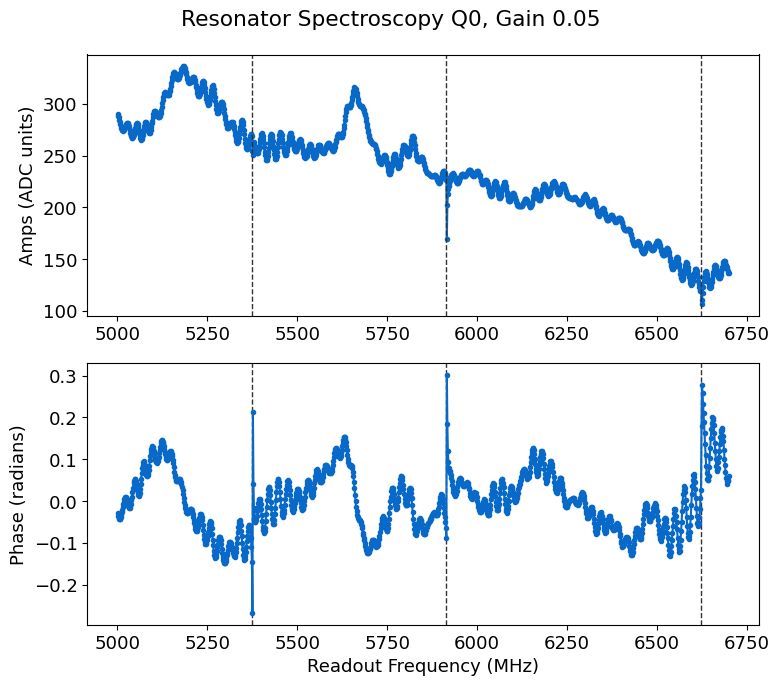

In [11]:
rspecc.analyze(peaks=True, debug=True, fit=False, prom=0.05)
rspecc.display(peaks=True, fit=False)
res_values = rspecc.data['coarse_peaks']

Can delete values from res_values if they don't seem to be real res_values. 

In [ ]:
res_values = np.delete(res_values, 2)

## Fine

This will fit the resonance amplitude

### First time after running coarse scan, using res_values list
Assumes you have the same number of res_values as qubits. 

In [ ]:
update=True

num_peaks = len(res_values)

for qi in len(res_values):    
    # Used for initial finding of resonance 
    rspec = meas.ResSpec(cfg_dict, qi=qi, params={'span':5, 'center':res_values[qi]})

    if update: rspec.update(cfg_dict['cfg_file'])

### General fine scan for fitting resonance

  0%|          | 0/44000 [00:00<?, ?it/s]

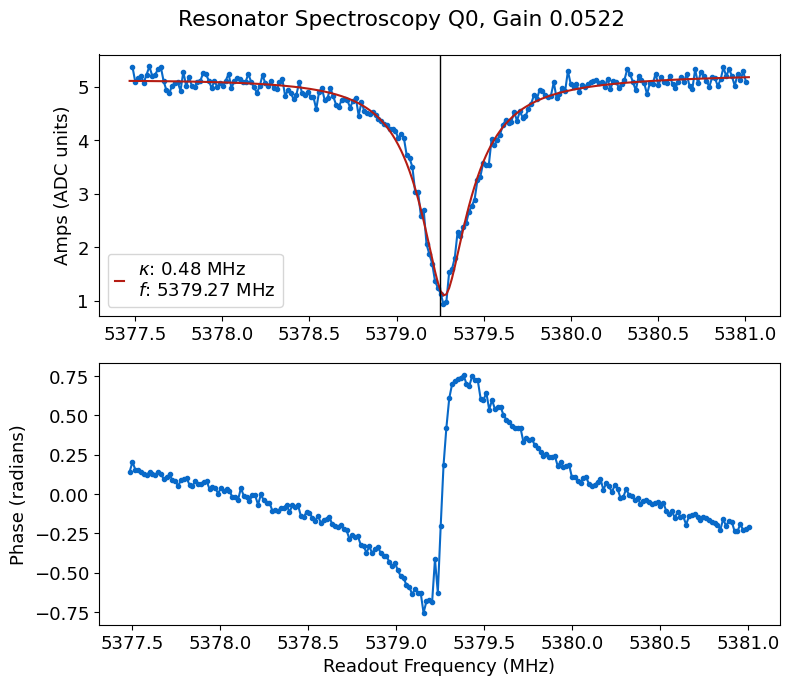

*Set cfg device.readout 0 frequency to 5379.269 from 5379.2469*
*Set cfg device.readout 0 kappa to 0.4845 from 0.5082*
*Set cfg device.readout 0 qi to 5.2701 from 4.2005*
*Set cfg device.readout 0 qe to 1.4067 from 1.4153*


In [240]:
# Just run one  
update=True

qubit_list = np.arange(3)
qubit_list=[0]
for qi in qubit_list:    
    # Fully automated, using previous fit to kappa tp set s[am]
    rspec = meas.ResSpec(cfg_dict, qi=qi, params={'span':'kappa'})
    
    # Manually set params
    #rspec = meas.ResSpec(cfg_dict, qi=qi, params={'span':6, 'gain':0.0045})
    if update: rspec.update(cfg_dict['cfg_file'])

#plot will appear weird first because it plots the resonator frequency in the config on the same plot

## Resonator Power Spectroscopy 

Find a good value for gain to park your readout at until you run readout optimization. From the 2D sweep that is produced, choose a value for gain that is right before the resonator 'breaks' (goes from e -> f). Want to choose a high value for gain because we want to be in the shot noise limited regime which increases our signal:noise ratio. The gain value should be saved in <code>auto_cfg.device.readout.gain</code>

  0%|          | 0/20 [00:00<?, ?it/s]

High power peak [MHz]: 5376.2828
Low power peak [MHz]: 5379.3473
Lamb shift [MHz]: -3.0645


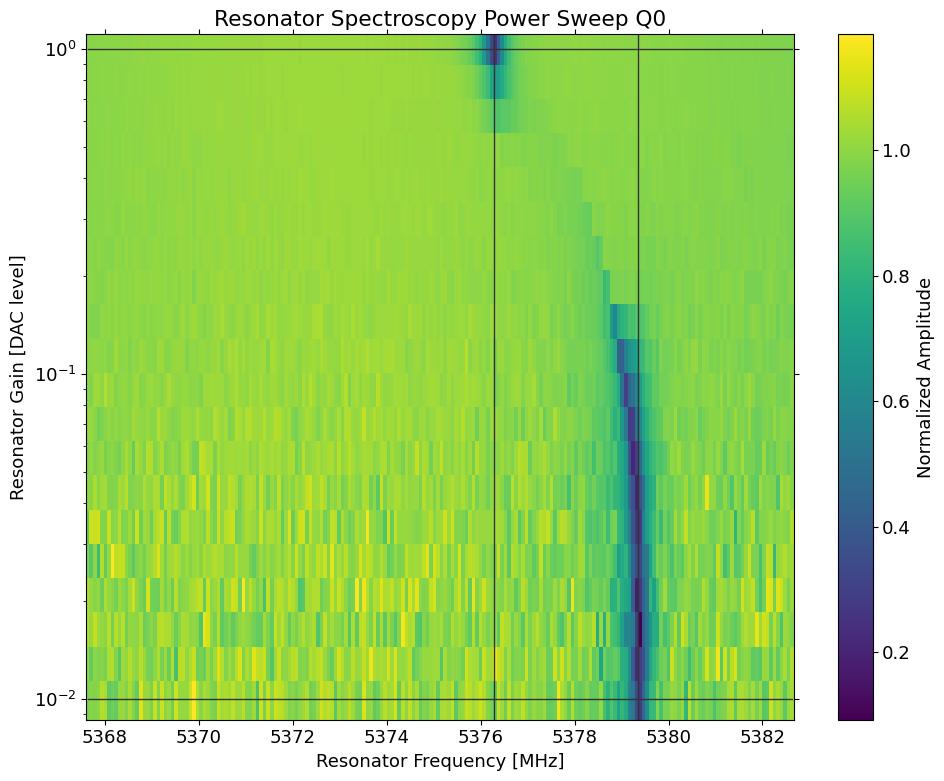

*Set cfg device.readout 0 lamb to -3.0645 from -2.9203*


  0%|          | 0/20 [00:00<?, ?it/s]

High power peak [MHz]: 5915.2609
Low power peak [MHz]: 5924.1279
Lamb shift [MHz]: -8.8670


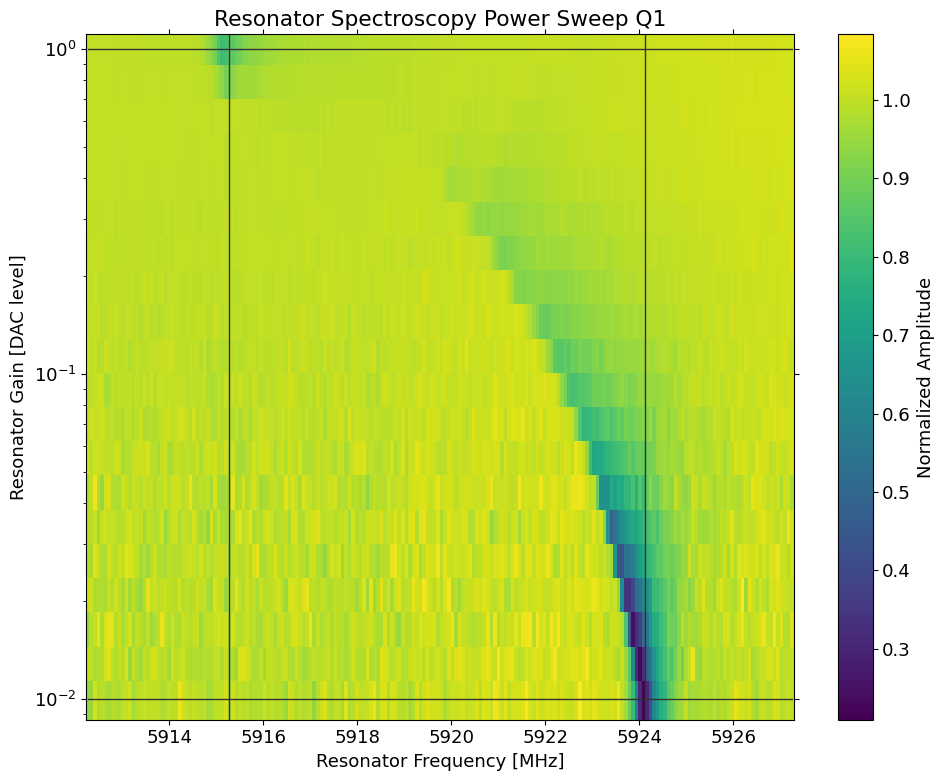

*Set cfg device.readout 1 lamb to -8.867 from -8.723*


In [181]:
update=True
d=[]

qubit_list = np.arange(13,20)
qubit_list=[0,1]

for qi in qubit_list:
    rpowspec=meas.ResSpecPower(cfg_dict, qi=qi)
    #rpowspec=meas.ResSpecPower(cfg_dict, qi=qi, params={'max_gain':0.08,'expts_gain':30})
    d.append(rpowspec)
    if update:
        auto_cfg = config.update_readout(cfg_path, 'lamb', rpowspec.data['lamb_shift'], qi)


In [159]:
rpowspec.data['fit']

[array([ 1.77521580e+02, -1.36898744e+02,  6.62153573e+03,  2.56928817e-01]),
 array([ 4.69783154e-01, -1.17455219e-01,  6.65330480e+03, -6.06196555e-01])]

In [14]:
rpowspec.print()

gain: 0.05
reps: 0.0625
soft_avgs: 1
length: 5
final_delay: 5
pulse_e: False
pulse_f: False
qubit: [2]
qubit_chan: 1
long_pulse: False
loop: False
phase_const: False
active_reset: False
kappa: 0.7359
center: 6519.8049
expts: 200
span: 5
rng: 300
max_gain: 1
start_gain: 0.003
step_gain: 0.05
expts_gain: 30
f_off: 1
min_reps: 100
log: True
start: 6516.3049
frequency: <qick.asm_v2.QickParam object at 0x000002159F239B50>


In [ ]:
auto_cfg = config.load(cfg_path)
horz_line = auto_cfg.device.readout.gain
handy.plot_many(d, title='Resonator Power', save_path=cfg_dict['expt_path'], chan='amps', yax='log', norm=True, horz_line=horz_line)

### Save gain values 

In [ ]:
# assign the resonator gain to the results config file
gain_values = [0.1,0.01]
for i in range(num_qubits):
    auto_cfg = config.update_readout(cfg_file, 'gain', int(gain_values[i]), i)

# Qubit Spectroscopy

## Find qubits

More automated, best to use once you're confident of qubit location and just refinding it 

Performing fine scan


  0%|          | 0/400000 [00:00<?, ?it/s]

R2:0.053	Fit par error:0.392	 Best fit:b'avgi'


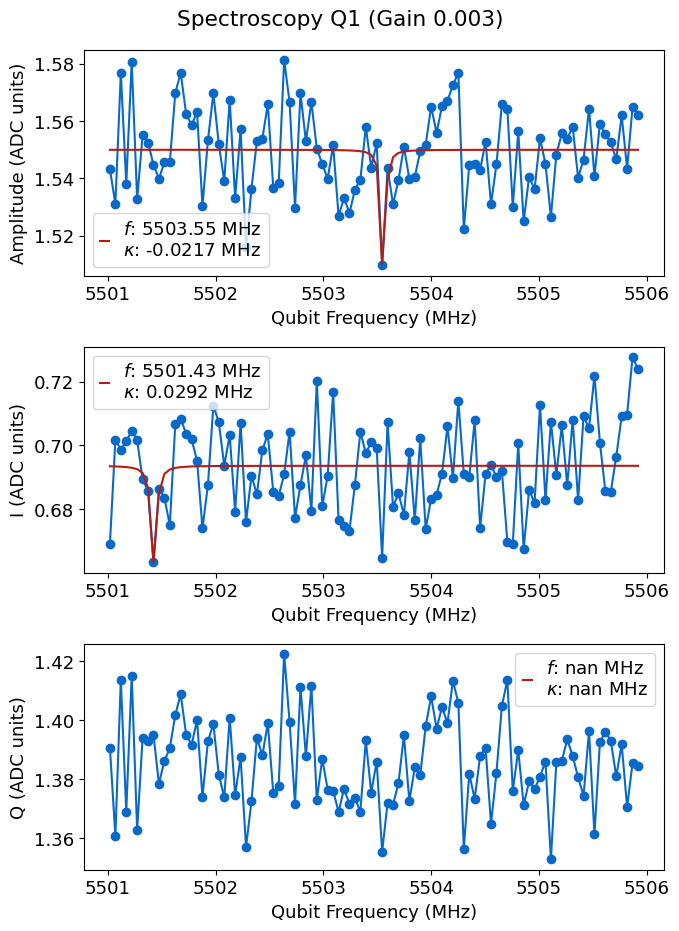

Performing medium scan


  0%|          | 0/400000 [00:00<?, ?it/s]

R2:0.789	Fit par error:0.032	 Best fit:b'avgi'


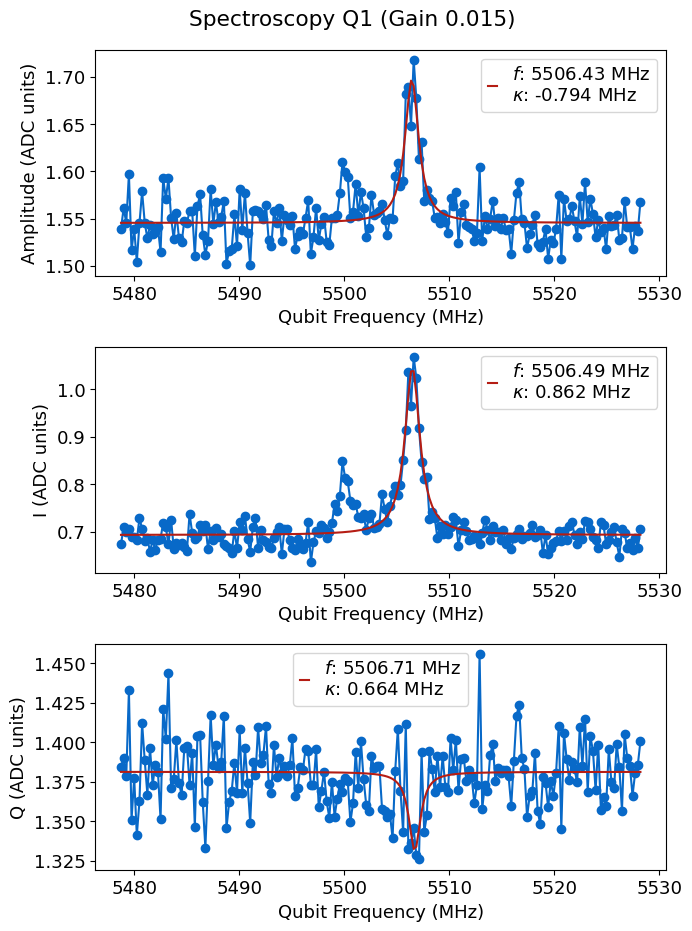

*Set cfg device.qubit 1 f_ge to 5506.4854 from 5503.4687*
Performing fine scan


  0%|          | 0/400000 [00:00<?, ?it/s]

R2:0.968	Fit par error:0.016	 Best fit:b'avgi'


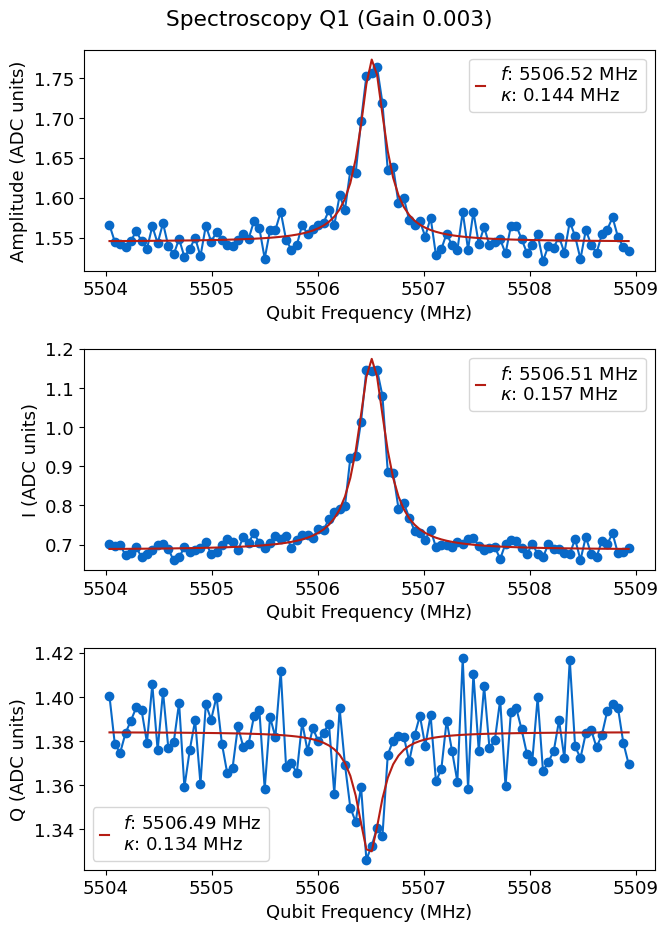

*Set cfg device.qubit 1 f_ge to 5506.5107 from 5506.4854*
Found qubit 1


In [203]:
qubit_list= [1]
#qubit_list = np.arange(13,20)
bad_qubits=[]
for qi in qubit_list:
    status, ntries = qubit_tuning.find_spec(qi, cfg_dict, start='fine')
    if not status:
        bad_qubits.append(qi)

## General search, specify width 

fine, medium, coarse, huge (will change scan width and power)

Uses config values of low_gain (gain to use for finest scan), which sets overall gain for device and spec_gain (set indepedently for each qubit) to decide how much power to apply

  0%|          | 0/80000 [00:00<?, ?it/s]

R2:0.617	Fit par error:0.069	 Best fit:b'avgq'


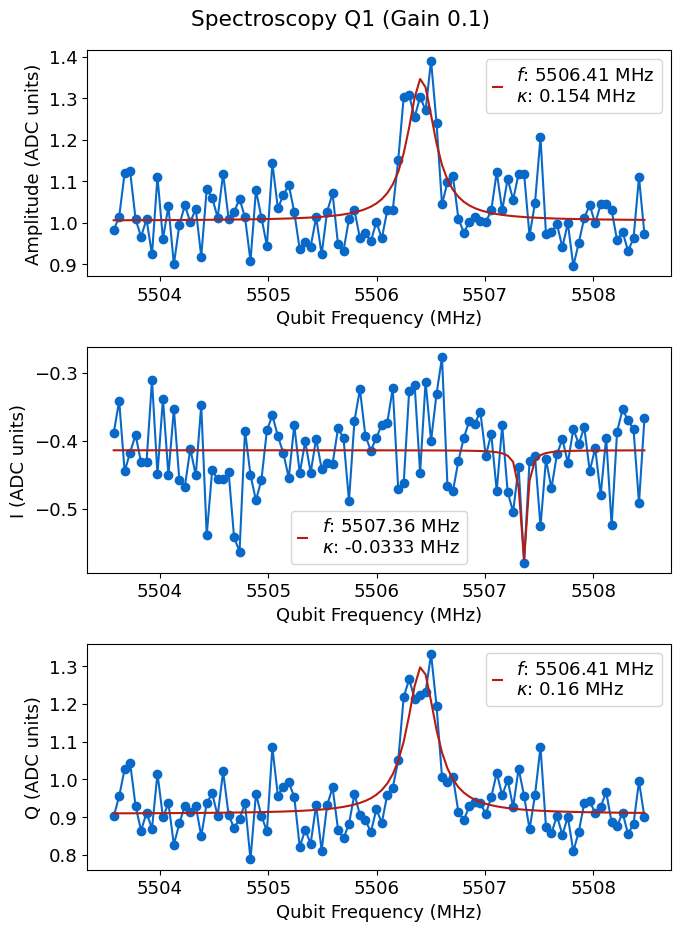

*Set cfg device.qubit 1 f_ge to 5506.4141 from 5506.0233*
*Set cfg device.qubit 1 kappa to 0.3209 from 1.1936*


In [109]:
update=True

#qubit_list = np.arange(5)
qubit_list = [1]
for qi in qubit_list: 
    # Default, just specifiy style 
    #qspec=meas.QubitSpec(cfg_dict, qi=qi, style='coarse')
    
    # Different examples of params you might give; frequency can be specified as start and span or if no start given, center is f_ge from config
    params={'start':5450,
            'span':100,
            'expts':1000,
            'gain':0.1,
            'reps':1000,
            #'length':3,
            }
    #qspec=meas.QubitSpec(cfg_dict, qi=qi, style='coarse',params=params)
    qspec=meas.QubitSpec(cfg_dict, qi=qi, style='fine',params={'gain':0.1})
    if update and qspec.status: 
        auto_cfg = config.update_qubit(cfg_path, 'f_ge', qspec.data["best_fit"][2], qi)
        auto_cfg = config.update_qubit(cfg_path, 'kappa',2*qspec.data["best_fit"][3], qi)
    else:
        print(f'Bad qubit! qi={qi}')

## Stark (not tested yet)

In [ ]:
qi=0
qspec=meas.StarkSpec(cfg_dict, qi=qi, style='medium')

## Power sweep

### Multiple wide scans looking for qubit

Qubit Number:   0%|          | 0/1 [00:00<?, ?it/s]

Start Frequency Sweep:   0%|          | 0/3 [00:00<?, ?it/s]

Unexpected parameters found in params: {'rng', 'expts_gain', 'max_gain', 'log'}
Unexpected parameters found in params: {'qubit', 'readout_length', 'soft_avgs', 'qubit_chan', 'length', 'gain', 'checkEF', 'pulse_type', 'start', 'final_delay', 'active_reset', 'sep_readout'}


  0%|          | 0/10 [00:00<?, ?it/s]

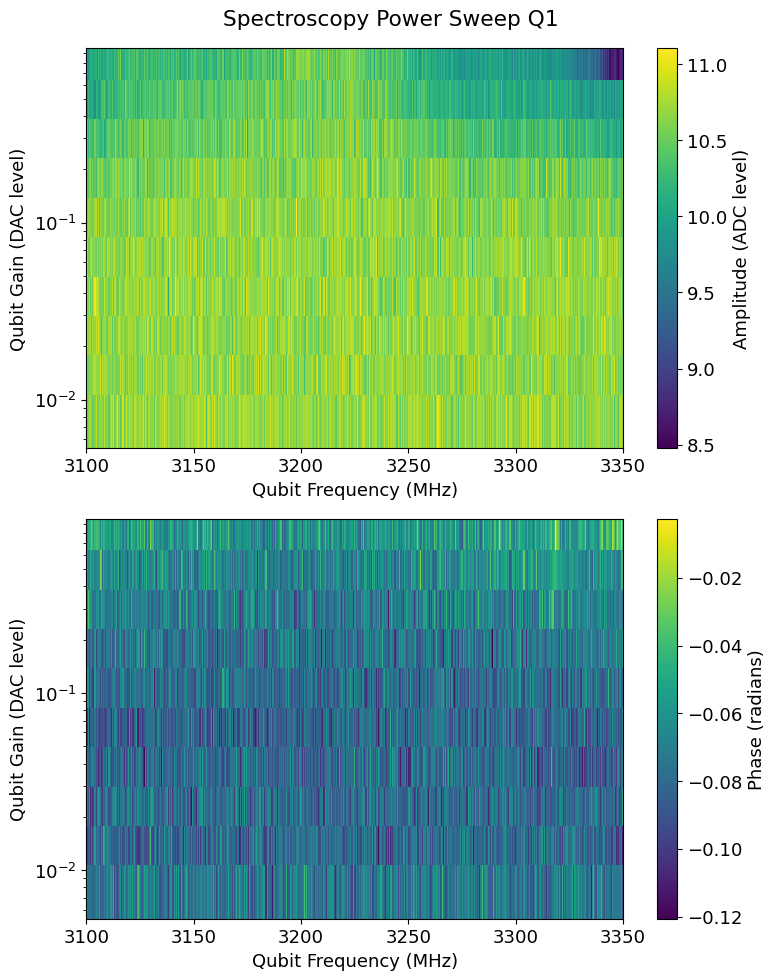

Unexpected parameters found in params: {'rng', 'expts_gain', 'max_gain', 'log'}
Unexpected parameters found in params: {'qubit', 'readout_length', 'soft_avgs', 'qubit_chan', 'length', 'gain', 'checkEF', 'pulse_type', 'start', 'final_delay', 'active_reset', 'sep_readout'}


  0%|          | 0/10 [00:00<?, ?it/s]

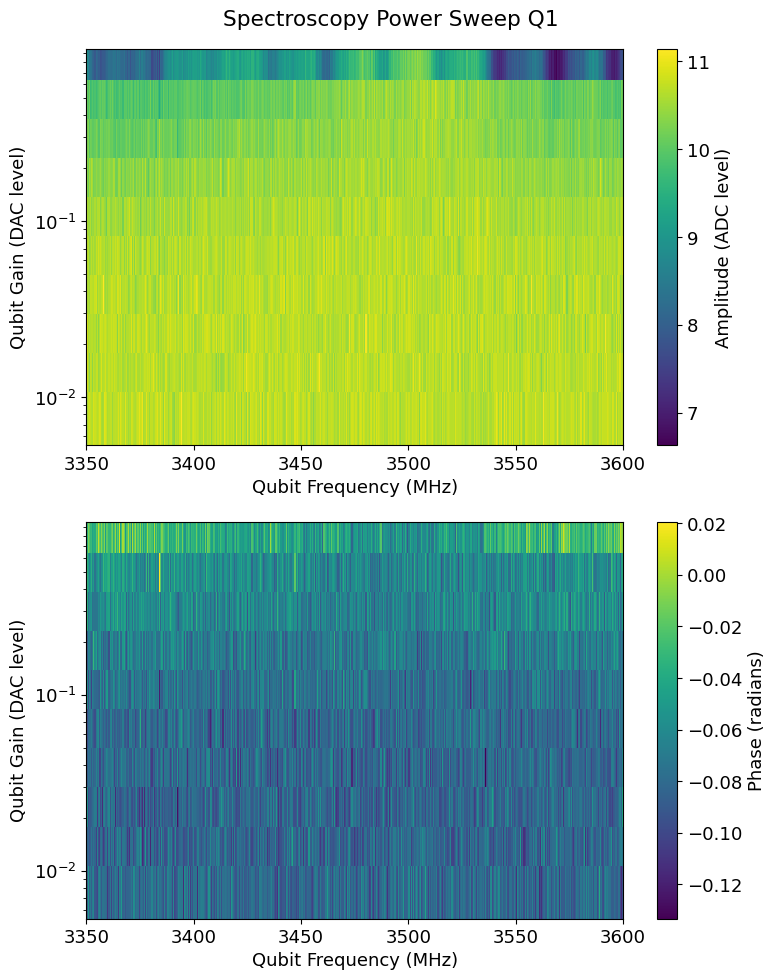

Unexpected parameters found in params: {'rng', 'expts_gain', 'max_gain', 'log'}
Unexpected parameters found in params: {'qubit', 'readout_length', 'soft_avgs', 'qubit_chan', 'length', 'gain', 'checkEF', 'pulse_type', 'start', 'final_delay', 'active_reset', 'sep_readout'}


  0%|          | 0/10 [00:00<?, ?it/s]

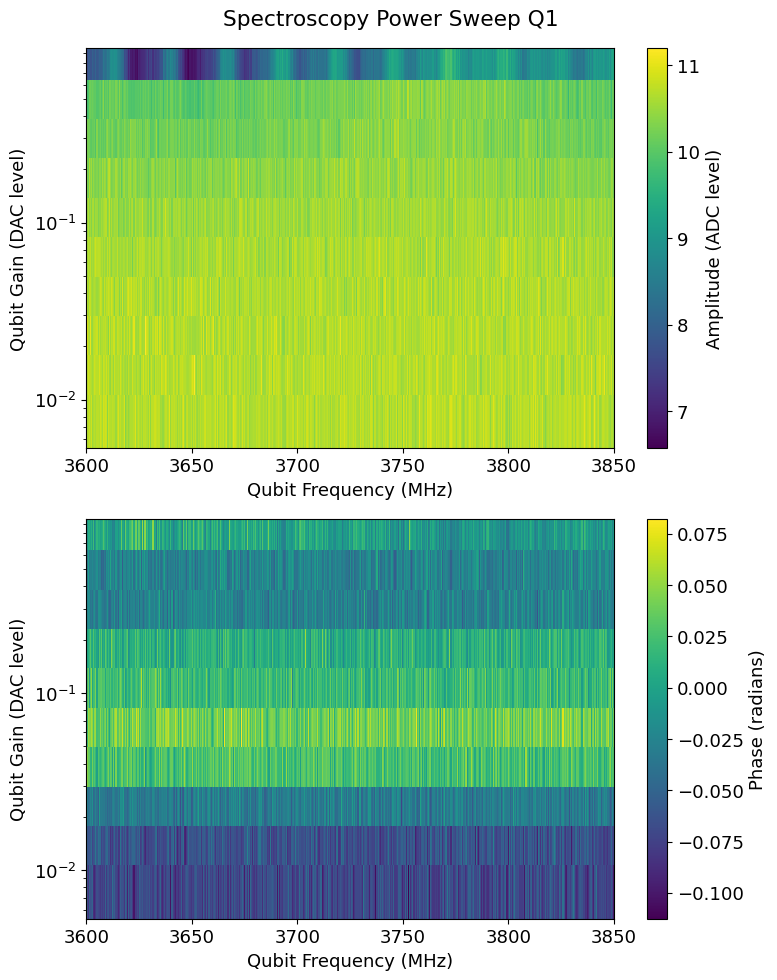

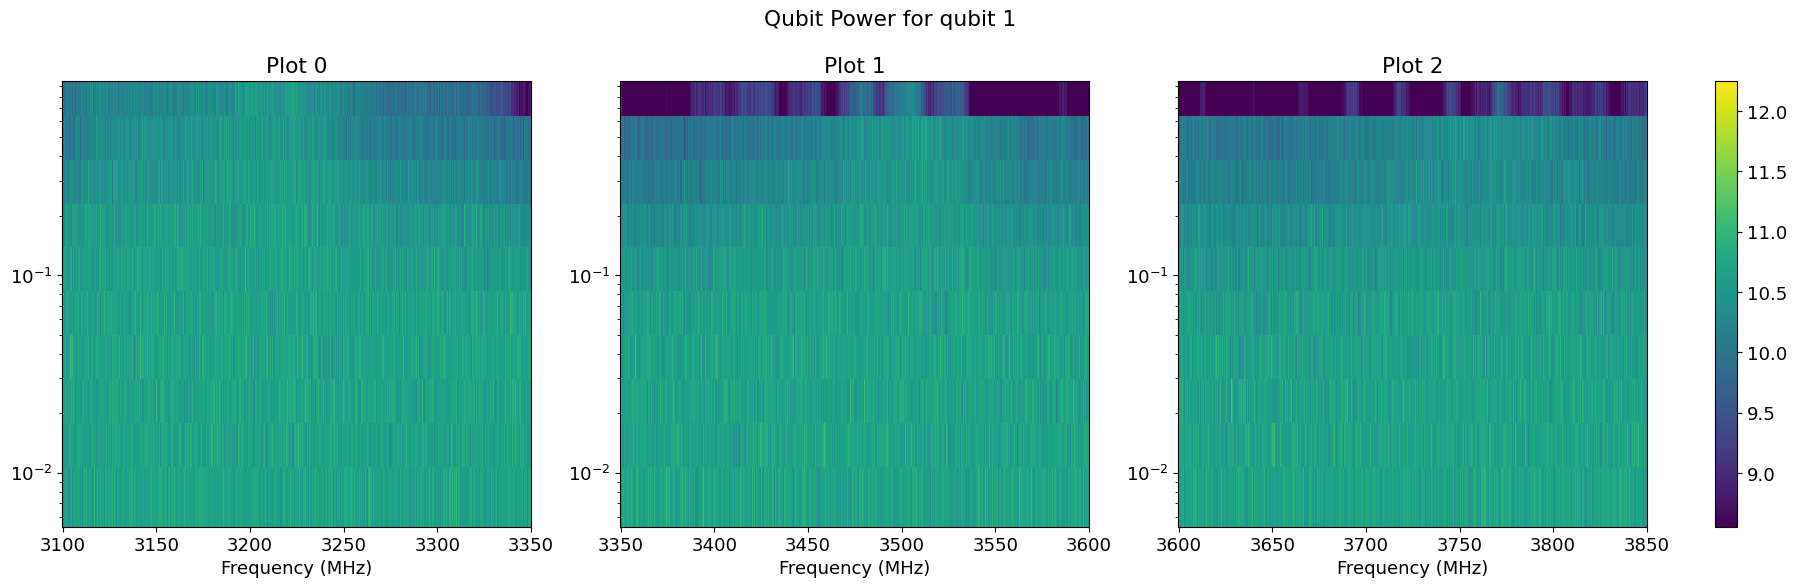

In [ ]:
qubit_list = np.arange(20)
qubit_list=[1]

span = 250
start_all = [2000, 3100, 3400]
end_all = [4780, 3700, 4250]
sensitivities = [0.8, 0.4, 0.2]

d = []
for qi in tqdm(qubit_list, desc='Qubit Number'):
    starts = np.arange(start_all[qi], end_all[qi], span)
    qresults = []
    for start in tqdm(starts, desc=f'Start Frequency Sweep'):
        q_res = meas.QubitSpecPower(
            cfg_dict, 
            qi=qi, 
            style='coarse', 
            params={
                'max_gain':0.8,
                'start':start,
                'span':span,
                'rng':100,
                'reps':800}
        )#,'start':3000,'span':300'})
        qresults.append(q_res)
    
    # Handy plot
    handy.plot_many_limited(
        qresults, 
        title=f'Qubit Power for qubit {qi}', 
        save_path=cfg_dict['expt_path'],
        yax='log', 
        chan='amps', 
        individial_fig_size= (6,6), 
        xlabel='Frequency (MHz)',
        sensitivity =  sensitivities[qi],
        save = False,
    )
    d.append(q_res)
    plt.show()

### general Scan

Unexpected parameters found in params: {'max_gain', 'log', 'expts_gain', 'rng'}
Unexpected parameters found in params: {'sep_readout', 'length', 'gain', 'qubit_chan', 'soft_avgs', 'final_delay', 'pulse_type', 'readout_length', 'start', 'active_reset', 'checkEF', 'qubit'}


  0%|          | 0/10 [00:00<?, ?it/s]

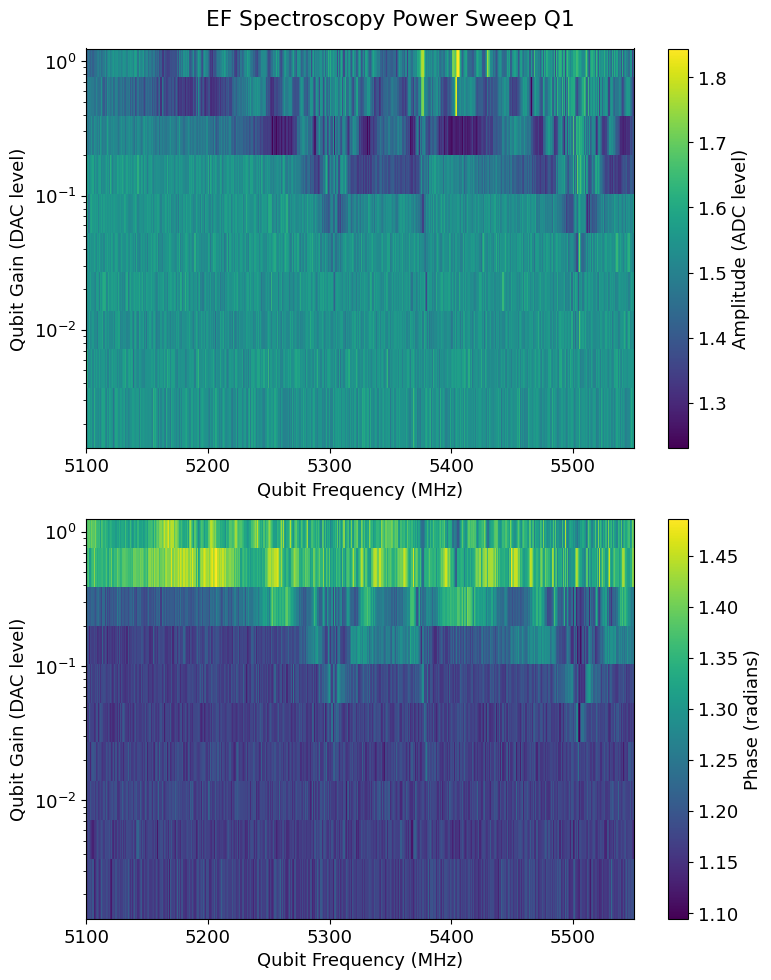

Unexpected parameters found in params: {'max_gain', 'log', 'expts_gain', 'rng'}
Unexpected parameters found in params: {'sep_readout', 'length', 'gain', 'qubit_chan', 'soft_avgs', 'final_delay', 'pulse_type', 'readout_length', 'start', 'active_reset', 'checkEF', 'qubit'}


  0%|          | 0/10 [00:00<?, ?it/s]

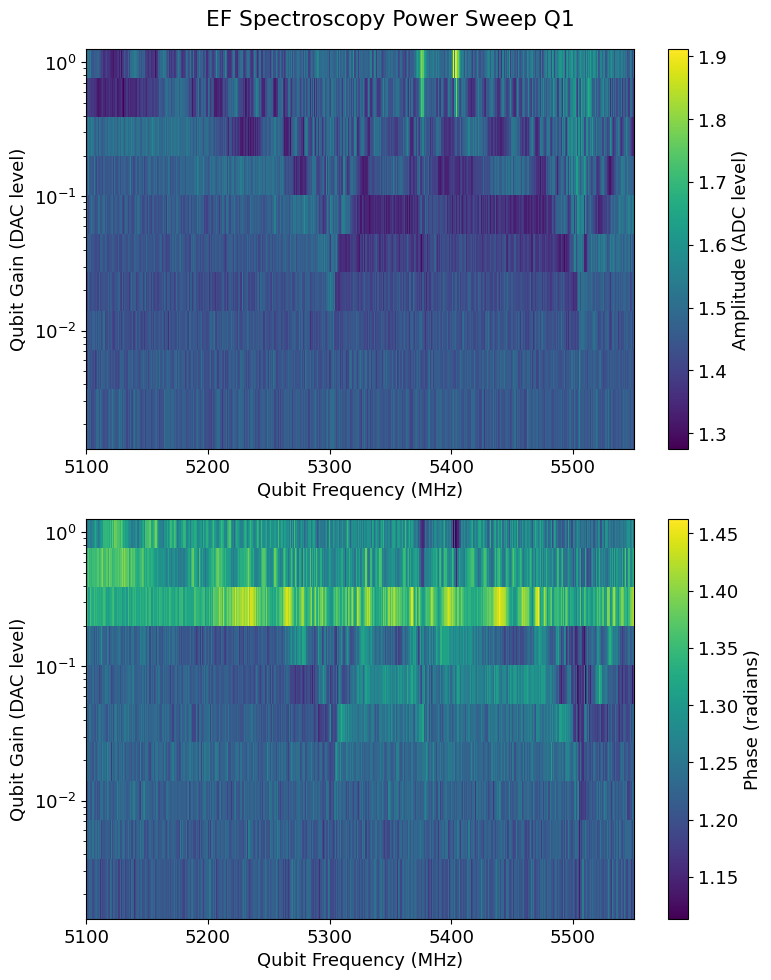

Unexpected parameters found in params: {'max_gain', 'log', 'expts_gain', 'rng'}
Unexpected parameters found in params: {'sep_readout', 'length', 'gain', 'qubit_chan', 'soft_avgs', 'final_delay', 'pulse_type', 'readout_length', 'start', 'active_reset', 'checkEF', 'qubit'}


  0%|          | 0/10 [00:00<?, ?it/s]

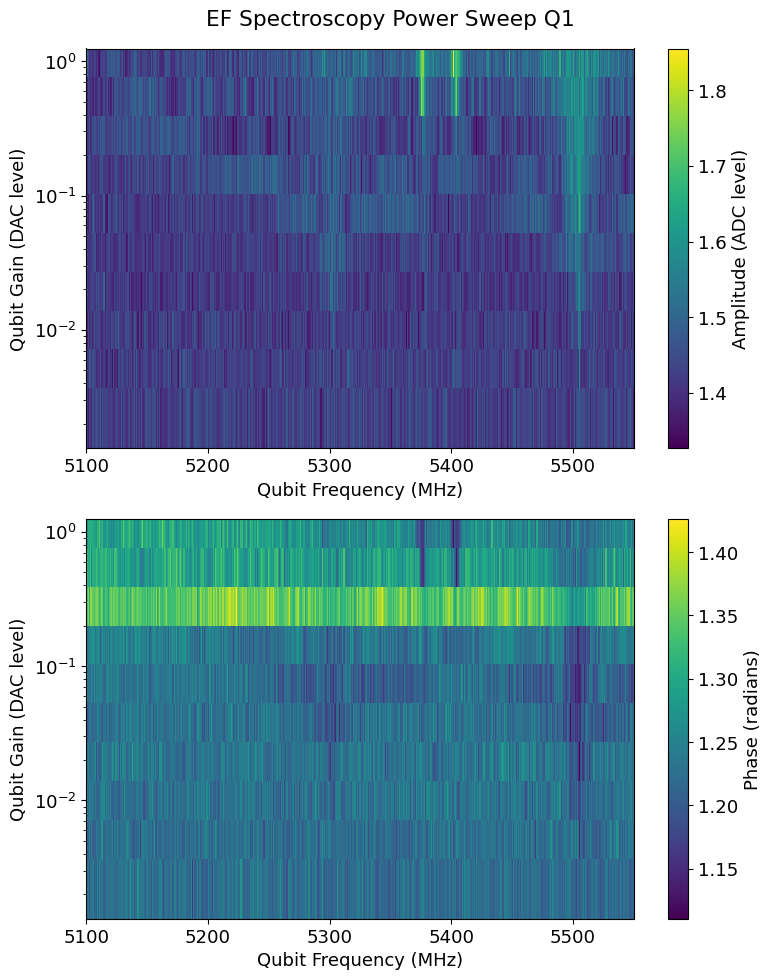

In [301]:
qubit_list=[1]
params={'start':5100,
        'span':450,
        'reps':1500,
        'expts':500, 
        'rng':400, 
        'checkEF':True, 
        'length':2}
len_list = [1,3,5]
for l in len_list: 
        for qi in qubit_list:
                params['length'] = l
                #qspec_pow = meas.QubitSpecPower(cfg_dict, qi=qi, style='coarse')
                qspec_pow = meas.QubitSpecPower(cfg_dict, qi=qi, style='coarse', params=params)
                #qspec_pow = meas.QubitSpecPower(cfg_dict, qi=qi, style='', params={'start':3700,'span':600,'reps':1500,'expts':1200, 'max_gain':0.4, 'length':1,'sep_readout':True})

### Narrow scan

Unexpected parameters found in params: {'max_gain', 'log', 'expts_gain', 'rng'}
Unexpected parameters found in params: {'sep_readout', 'length', 'gain', 'qubit_chan', 'soft_avgs', 'final_delay', 'pulse_type', 'readout_length', 'start', 'active_reset', 'checkEF', 'qubit'}


  0%|          | 0/10 [00:00<?, ?it/s]

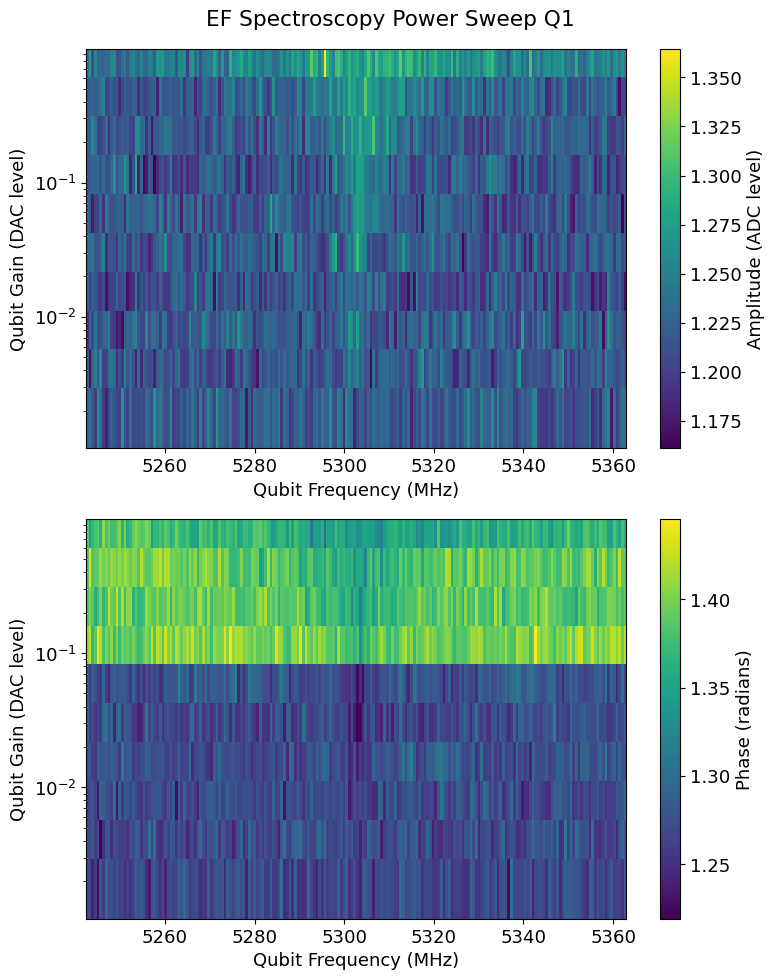

In [288]:
qq=[]

# qubit_list = np.arange(20)
qubit_list=[1]
for qi in qubit_list:
    qspec_pow = meas.QubitSpecPower(cfg_dict, qi=qi, style='medium', params={'checkEF':True,'rng':400,'reps':3000,'length':20,'max_gain':0.8})
    
    # Nice for pretty pics once you have T1 measurement. 
    #qspec_pow = meas.QubitSpecPower(cfg_dict, qi=qi, style='fine', params={'rng':300,'max_gain':1, 'len':1})
    qq.append(qspec_pow)

# When measuring many qubits, can do a bunch of color plots this way
#handy.plot_many(qq, title='Qubit Power Amps 0.6-0.2', save_path=cfg_dict['expt_path'], yax='log', chan='amps')
#handy.plot_many(qq, title='Qubit Power Phase 0.6-0.2', save_path=cfg_dict['expt_path'], yax='log', chan='phases')

# Coherent scans

## Fast tuneup

Options are: 

first_time: assume we don't know t1 time,don't have single shot working

single: do single shot readout optimization 

readout: set readout frequency based on resonator fit

In [ ]:
qubit_list = np.arange(20)
qubit_list=np.delete(qubit_list, [5,13])
# Worst issue with this right now is when the qubit frequency is not correct and readout is bad; gets stuck doing ramsey/spectroscopy forever. In this case, cancel it and go back to find qubits, try changing readout gain. 
plt.rcParams.update({'font.size': 11})
qubit_list=[19]
for qi in qubit_list: 
    qubit_tuning.tune_up_qubit(qi, cfg_dict, first_time=False, single=True, readout=True)

## Time tracking

In [ ]:
scan_length = 48
cfg_dict['expt_path']=expt_path
qubit_list = np.arange(20)
bad_qubits = [0,5,13]
qubit_list = np.delete(qubit_list, bad_qubits)

tt=qubit_tuning.time_tracking(qubit_list, cfg_dict,display=False,total_time=scan_length)
cfg_dict['expt_path']=expt_path

## Rabi

### Amplitude

Uses gain/sigma set in pulses part of config

  0%|          | 0/12000 [00:00<?, ?it/s]

R2:0.980	Fit par error:0.011	 Best fit:b'avgi'


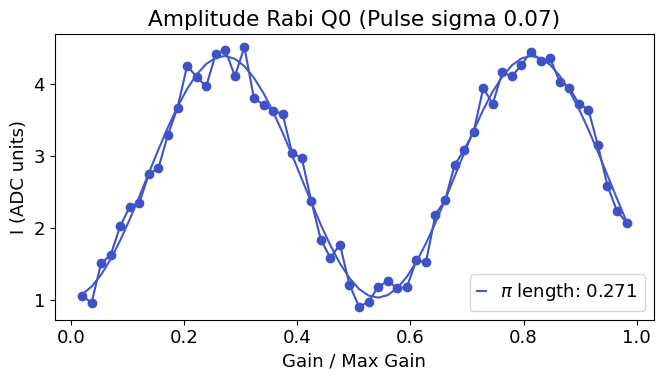

*Set cfg device.qubit 0 ('pulses', 'pi_ge', 'gain') to 0.2709 from 0.2634*


In [317]:
qubit_list = np.arange(13,20)
qubit_list=[0]

update=True

for qi in qubit_list: 
    amp_rabi = meas.RabiExperiment(cfg_dict,qi=qi)
    
    # Fully customized version
#    amp_rabi = meas.RabiExperiment(cfg_dict,qi=qi, params={'active_reset':True, 'gain':0.25,'freq':4370, 'reps':1000,'soft_avgs':3,'pulse_type':'const','sigma':1})

    if update and amp_rabi.status:
        config.update_qubit(cfg_path, ('pulses','pi_ge','gain'), amp_rabi.data['pi_length'], qi)
        

#### Chevron

Unexpected parameters found in params: {'span_f', 'expts_f'}


  0%|          | 0/30 [00:00<?, ?it/s]

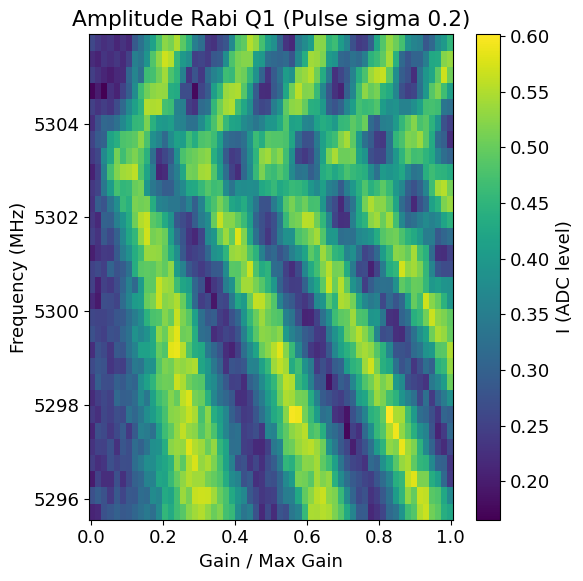

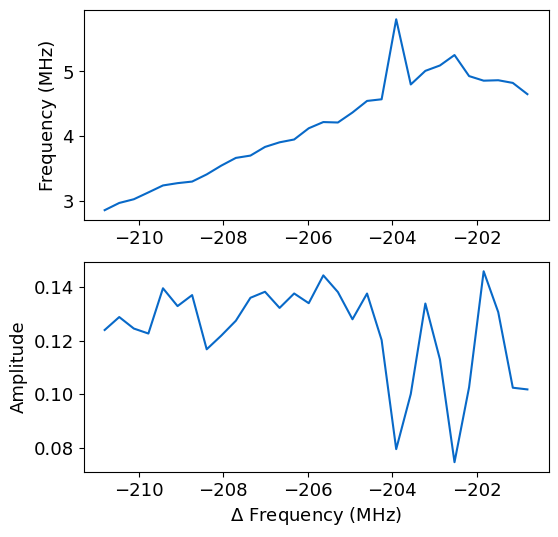

In [278]:
d2=[]
qubit_list = np.arange(18)
qubit_list=[1]

for qi in qubit_list: 
    amp_rabi_chevron = meas.RabiChevronExperiment(cfg_dict,qi=qi, params={'span_f':10,'checkEF':True})
    d2.append(amp_rabi)

#handy.plot_many(d2, title='Rabi Chevron Phase', save_path=cfg_dict['expt_path'], chan='phases')

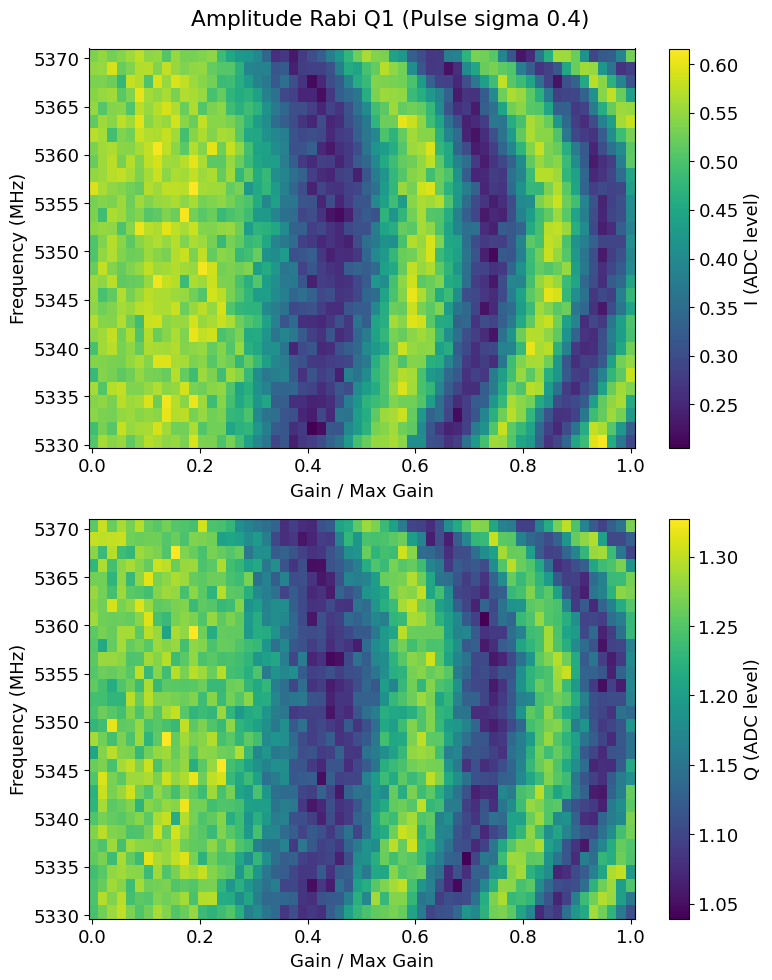

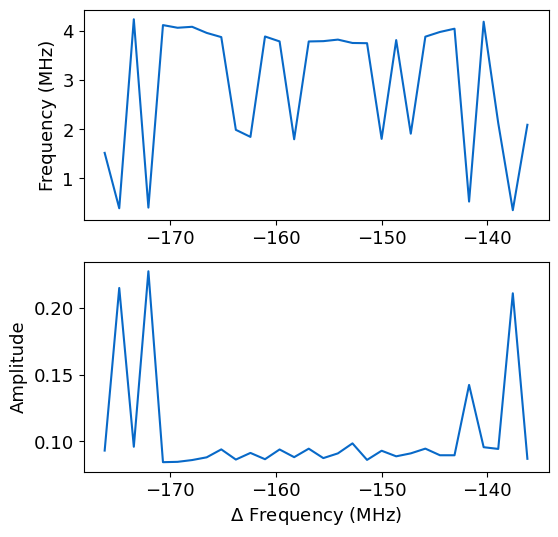

In [264]:
amp_rabi_chevron.display(plot_both=True)

#### 2 Qubit Rabi

In [ ]:
qi=[0,10]
amp_rabi = meas.Rabi_2Q(cfg_dict,qi=qi, params={'active_reset':False})

### Length -- Uses const pulses so do not use to set up pi pulses

  0%|          | 0/12000 [00:00<?, ?it/s]

R2:-0.168	Fit par error:0.085	 Best fit:b'avgi'


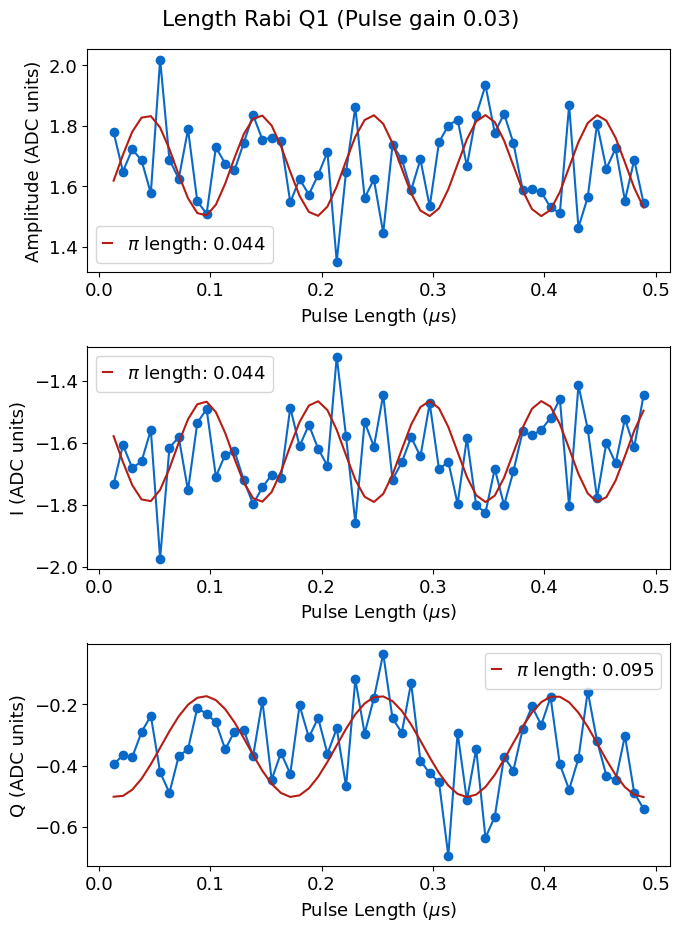

In [96]:
qubit_list = [1]
# This does not work with gaussian pulses due to multiplying qickparams issues -- need to fix
for qi in qubit_list: 
    # Needs to have params of sweep: length and type: const
    len_rabi = meas.RabiExperiment(cfg_dict,qi=qi, params={'sweep':'length', 'type':'const'})

#### Chevron

In [ ]:
qubit_list = np.arange(20)
qubit_list=[2]
for qi in qubit_list: 
    len_rabi = meas.RabiChevronExperiment(cfg_dict,qi=qi, params={'sweep':'length',"type":"const", 'sigma':0.605, 'span_f':20})
    #len_rabi = meas.RabiChevronExperiment(cfg_dict,qi=qi, params={'sweep':'length',"type":"const", 'sigma':0.205, 'expts_f':60, 'span_f':150, 'gain':0.4,'start_f':6280,'soft_avgs':4})

## Ramsey

  0%|          | 0/40000 [00:00<?, ?it/s]

R2:0.902	Fit par error:0.035	 Best fit:b'avgi'


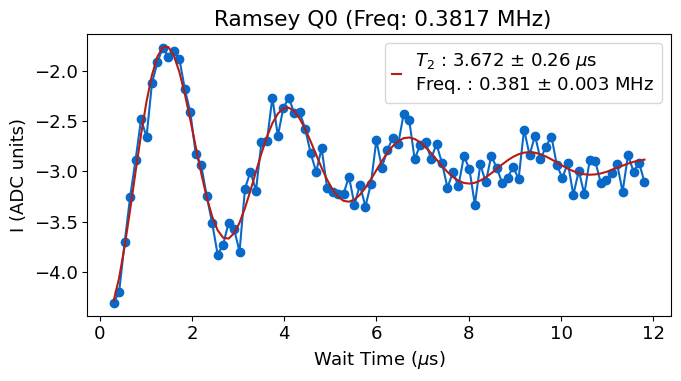

*Set cfg device.qubit 0 f_ge to 3964.852 from 3964.851*
*Set cfg device.qubit 0 T2r to 3.67 from 3.93*


In [221]:
qubit_list=[0]
update = True
for qi in qubit_list:
    t2r = meas.T2Experiment(cfg_dict, qi=qi, max_err=10)

    # Manually configured
    # t2r = meas.T2Experiment(cfg_dict, qi=qi, max_err=10, params = {'ramsey_freq':1.0,'expts':expts, 'span':0.5,'start':0.01})
    if t2r.status and update:
        config.update_qubit(cfg_path, 'f_ge', t2r.data['new_freq'], qi)
        auto_cfg = config.update_qubit(cfg_path, 'T2r', t2r.data['best_fit'][3], qi, rng_vals=[1.5, max_t1], sig=2)
    else:
        print('T2 Ramsey fit failed')

### Use Ramsey to recenter

In [ ]:
qubit_list = [2]
for qi in qubit_list:
    status = qubit_tuning.recenter(qi,cfg_dict)            

### Ramsey coherence

In [ ]:
t1= qubit_tuning.get_coherence(meas.RamseyExperiment, qi, cfg_dict,par='T2r')

## T1

  0%|          | 0/24000 [00:00<?, ?it/s]

R2:0.978	Fit par error:0.044	 Best fit:b'avgi'


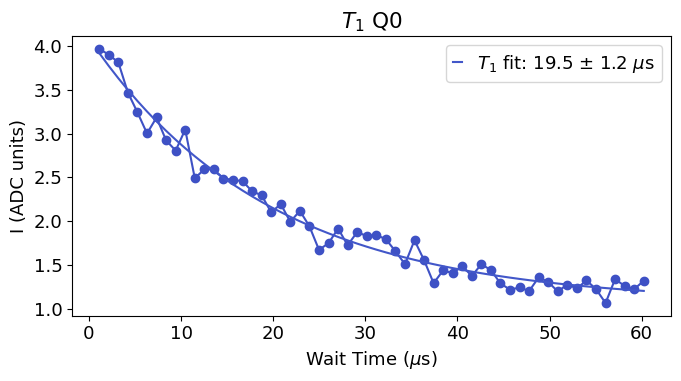

*Set cfg device.qubit 0 T1 to 19.47 from 16.54*
*Set cfg device.readout 0 final_delay to 116.79 from 99.22*
*Set cfg device.qubit 0 T2r to 19.47 from 16.54*
*Set cfg device.qubit 0 T2e to 38.93 from 33.07*


In [318]:
# If it's the first time, also set T2r and T2e as guesses 
update=True
first_time=True

qubit_list = np.arange(11,20)
qubit_list=[0]
for qi in qubit_list:
    t1 = meas.T1Experiment(cfg_dict, qi=qi)
    if update: t1.update(cfg_path, first_time=first_time)

### T1 coherence

Runs scan until scan is properly configured to be sensitive to T1

In [ ]:
qi=0
qubit_tuning.get_coherence(meas.T1Experiment,qi=qi,cfg_dict=cfg_dict,par='T1')

### Continuous scan at single point

In [ ]:
qi=0
meas.T1ContExperiment(cfg_dict,qi=qi, params={'shots':40000})

### T1 continuous 2Q

In [ ]:
qi = [10,0]
meas.T1_2Q(cfg_dict,qi=qi, )

In [ ]:
qi=[0,10]
scan_time = 0.1 #hours
number_of_scans = 1
shots = int(100000*scan_time*60/4)
print(shots)
for i in range(number_of_scans):
    meas.T1Cont2QExperiment(cfg_dict,qi=qi, params={'shots':shots, 'active_reset':False})


## Echo

  0%|          | 0/400000 [00:00<?, ?it/s]

R2:0.213	Fit par error:352.048	 Best fit:b'avgq'
R2:0.209	Fit par error:4.684	 Best fit:b'avgq'


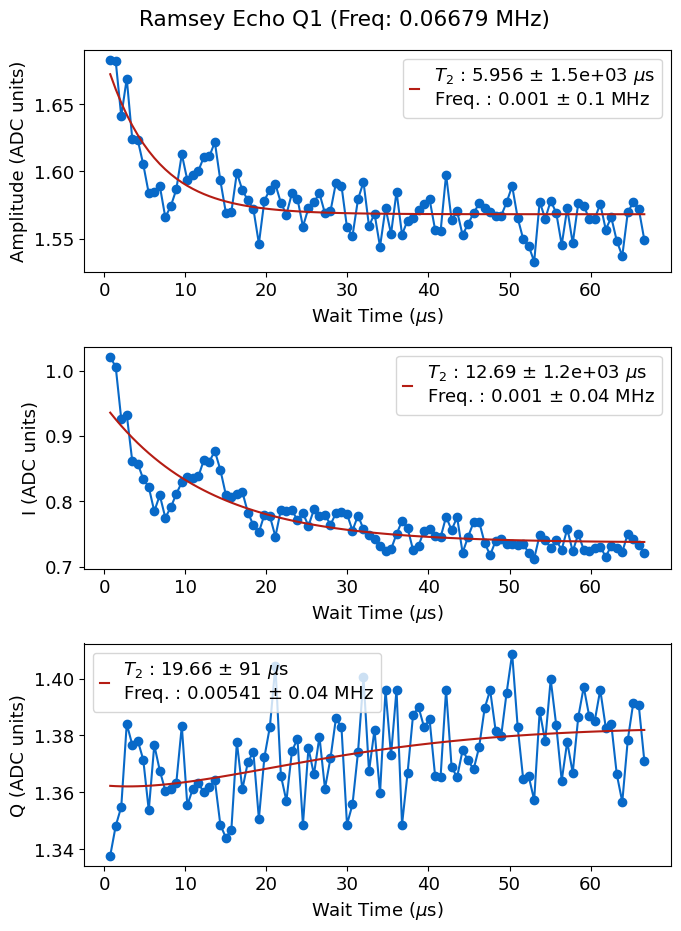

In [205]:
qubit_list = np.arange(20)
qubit_list=[1]
update=True
for qi in qubit_list:
    # Need to have experiiment type set to echo
    t2e = meas.T2Experiment(cfg_dict, qi=qi, params={'experiment_type':'echo'})
    if t2e.status and update:
        auto_cfg = config.update_qubit(cfg_path, 'T2e', t2e.data['best_fit'][3], qi,sig=2, rng_vals=[1.5, max_t1*2])

### Get echo coherence

In [ ]:
qi=6
t2e = qubit_tuning.get_coherence(meas.RamseyEchoExperiment, qi, cfg_dict,'T2e')

## Feedback checks

In [ ]:
qi=10
reset = meas.MemoryExperiment(cfg_dict, qi=qi, params={'shots':1, 'expts':200})

In [ ]:
# Don't do the active reset, just do the repeated measurement 
qi=1
shot = meas.RepMeasExperiment(cfg_dict, qi=qi, params={'shots':30000,'active_reset':True, 'setup_reset':True})
shot.check_reset()

# Single Shot

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

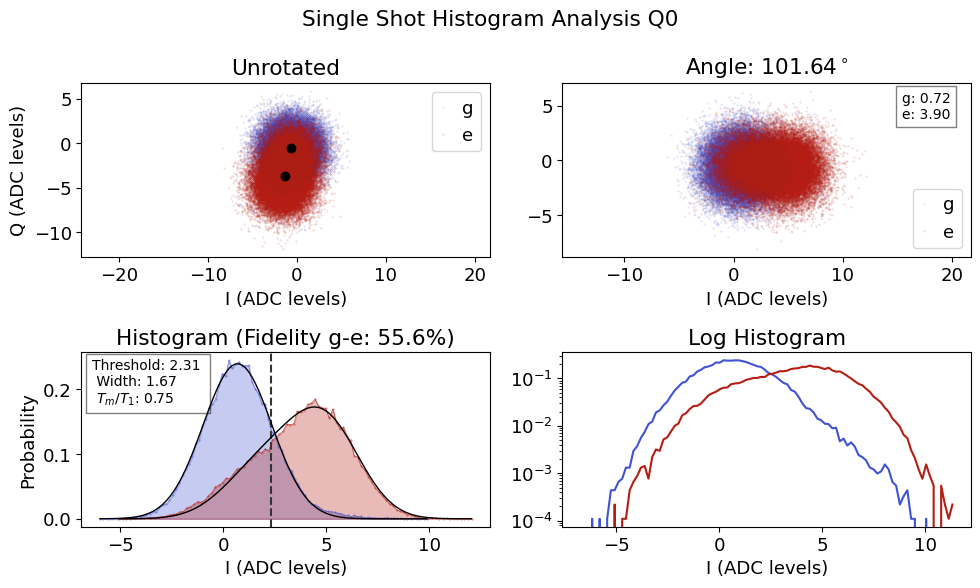

*Set cfg device.readout 0 phase to 101.6446 from 105.7413*
*Set cfg device.readout 0 threshold to 2.3097 from 2.8025*
*Set cfg device.readout 0 fidelity to 0.5556 from 0.5601*
*Set cfg device.readout 0 sigma to 1.666 from 1.8274*
*Set cfg device.readout 0 tm to 0.7459 from 0.697*
*Set cfg device.qubit 0 tuned_up to True from True*


In [226]:
# Single shot 
qubit_list = np.arange(13,20)
qubit_list =[0]

for qi in qubit_list:
    #shot=meas.HistogramExperiment(cfg_dict, qi=qi)

    # Configure number of shots
    shot=meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':50000})
    shot.update(cfg_path)
    

## Readout opt

### General sweep

Runs single shot experiments for many readout lengths, frequencies, gains and compares fidelity

In [225]:
update=True
low_gain=True # Chooses lowest gain/readout length within a few percent of maximum gain (often readout fidelity fairly flat as a function of gain at higher gain values) 

qubit_list=np.arange(3)
qubit_list=[0]

params = {'expts_f':1, 'expts_gain':7, 'expts_len':5}
#params = {'expts_f':10, 'expts_gain':1, 'expts_len':1}

# Specify exact ranges to use  
#params = {'expts_f':1, 'expts_gain':9, 'expts_len':9,'start_gain':0.45, 'span_gain':0.05,'start_len':2, 'span_len':5}

for qi in qubit_list: 
    # style='fine' varies parameters by 20%, style='' varies by 2x
    shotopt=meas.SingleShotOptExperiment(cfg_dict, qi=qi,params=params)#, style='fine')
    shotopt.analyze(low_gain=low_gain)
    if update: shotopt.update(cfg_dict['cfg_file'])

Unexpected parameters found in params: {'step_gain', 'step_f', 'step_len'}


  0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Run optimization until it converges

In [ ]:
qubit_list=np.arange(20)
qubit_list=[19]
params = {'expts_f':1, 'expts_gain':7, 'expts_len':7}

# do_res also runs res spec and resets readout frequency that way each round. 
qubit_tuning.meas_opt(cfg_dict, qubit_list, params, do_res=True)

### Vary trig_offset to see if it changes fidelity. 

In [ ]:
# Single shot 
qubit_list = np.arange(13,20)
qubit_list =[11]
trig_list = np.linspace(0.2,1,12)
fids =[]
for qi in qubit_list:
    for trig in trig_list: 
        config.update_readout(cfg_path, 'trig_offset', trig, qi);
        shot=meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':20000, 'trigger':trig})
        fids.append(shot.data['fids'][0])
    

### Play with LO freq (when using qick for LO)

In [ ]:
auto_cfg = config.load(cfg_path)
start_freq = auto_cfg.device.readout.frequency[qi]
start_mixer = auto_cfg.hw.soc.lo.mixer_freq[qi]
rng = np.linspace(-1000,1000,11)
fids=[]
for qi in qubit_list: 
    for r in rng: 
        config.update_lo(cfg_path, 'mixer_freq', start_mixer+r, qi)
        config.update_readout(cfg_path, 'frequency', start_freq-r, qi)
        shot=meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':20000})
        fids.append(shot.data['fids'][0])

config.update_lo(cfg_path, 'mixer_freq', start_mixer, qi)
config.update_readout(cfg_path, 'frequency', start_freq, qi)

#### Play with LO power

In [ ]:
qi = 11
gain_vals = [0.0375,0.05] 
fids = []
for gain in gain_vals:
    config.update_lo(cfg_path, 'gain', gain, qi)
    shotopt=meas.SingleShotOptExperiment(cfg_dict, qi=qi,params={'npts_f':5, 'npts_gain':5, 'npts_len':5})
    fids.append(shot.data['fids'][0])

### Adjust reps for fidelity 

In [ ]:
max_inc = 15 # dont' let it do more than 15x standard number of reps so that things don't take forever
qubit_list = [10]

auto_cfg = config.load(cfg_path)
for qi in qubit_list:
    config.update_readout(cfg_path, 'reps', 1/auto_cfg['device']['readout']['fidelity'][qi]**1.5, qi, rng_vals=[1,max_inc]);

## Active reset

### Check active reset at standard threshold

In [ ]:
# Setup reset uses the calibrated angle and runs active reset process at end, but also uses usual final_delay so that it's ok if reset not working
qubit_list = np.arange(15,20)
qubit_list=[3]
d=[]
for qi in qubit_list:
    shot = meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':100000,'active_reset':True, 'setup_reset':True})
    shot.check_reset()
    #config.update_readout(cfg_path, 'reset_e', shot.data['reset_e'], qi)
    #config.update_readout(cfg_path, 'reset_g', shot.data['reset_g'], qi)
    d.append(shot)

### Sweep threshold

In [ ]:
d = []
qi=10
auto_cfg = config.load(cfg_path)
threshold = auto_cfg['device']['readout']['threshold'][qi]
thresh = np.linspace(threshold-25,threshold+25,16)
#thresh = np.linspace(threshold-10,threshold+10,6)
for t in thresh:
    shot=meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':100000,'threshold_v':t, 'active_reset':True,'setup_reset':True}, display=False, progress=False)
    d.append(shot)
    #shot.check_reset()
tuneup.plot_reset(d)

### Turn off active reset for all config chans

In [ ]:
for qi in range(20):
    config.update_readout(cfg_path, 'active_reset',False, qi)

### Turn on active reset for channels where it seems to be working

In [ ]:
e_success = 0.15 # Ratio of e proportion after active reset compared to before
g_vs_e = 2 # Ratio of g proportion to e proportion after active reset

auto_cfg = config.load(cfg_path)
reset_e = auto_cfg['device']['readout']['reset_e']
reset_g = auto_cfg['device']['readout']['reset_g']
result = np.array(reset_e)< e_success | np.array(reset_g)/np.array(reset_e)<g_vs_e
for qi in range(20):
    config.update_readout(cfg_path, 'active_reset',bool(result[qi]), qi)

### Check reset (plotting result of reset)

In [ ]:
qubit_list = np.arange(11,20)
qubit_list =[17]
for qi in qubit_list:
    shot = meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':50000,'active_reset':True})
    shot.check_reset()

# Chi

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

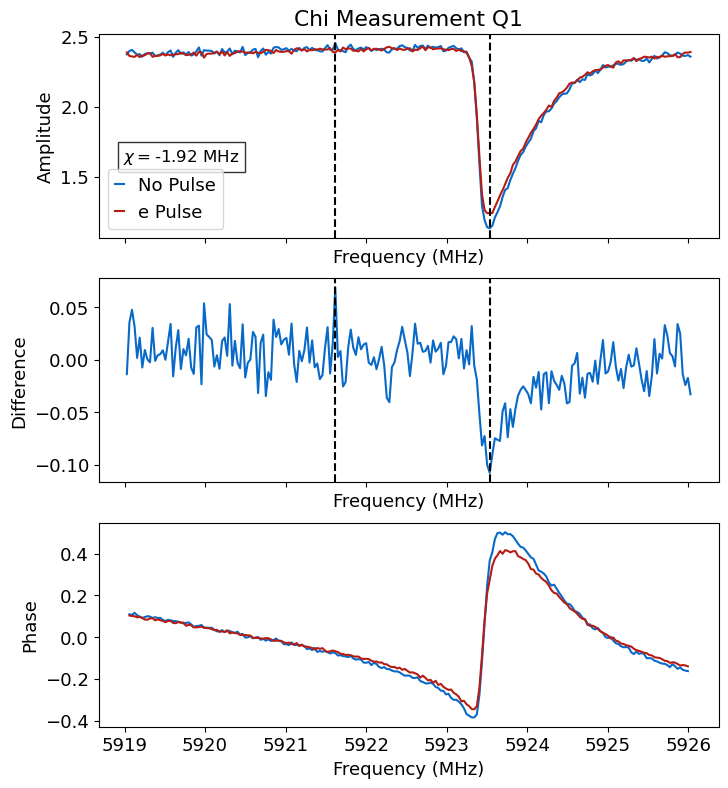

*Set cfg device.readout 1 chi to -1.9174 from 0*


In [290]:
# Need a tuned up pi pulse for this
#for i in range(num_qubits):
qubit_list = [1]
for qi in qubit_list: 
    chi, chi_val=tuneup.check_chi(cfg_dict, qi)
    auto_cfg = config.update_readout(cfg_path, 'chi', chi_val, qi)


# 2 Qubit

In [ ]:
t12q = meas.T1_2Q(cfg_dict, qi=[10,0], params={'active_reset':False, })

In [ ]:
rabi2q = meas.Rabi_2Q(cfg_dict, qi=[10,0], params={'active_reset':True})

# EF 

### Initial setting of frequencies based on guess for alpha

In [ ]:
# Initial set of the frequencyies based on guess for alpha 
alpha = -160
qubit_list = np.arange(3)
qubit_list =[1]
auto_cfg = config.load(cfg_path)
for i in qubit_list: 
    f_ge = auto_cfg['device']['qubit']['f_ge'][i]
    auto_cfg = config.update_qubit(cfg_path, 'f_ef', f_ge+alpha, i)

*Set cfg device.qubit 1 f_ef to 5366.532 from 3750*


## Spectroscopy EF

### General search

Performing medium scan


  0%|          | 0/200000 [00:00<?, ?it/s]

R2:0.573	Fit par error:0.051	 Best fit:b'avgi'


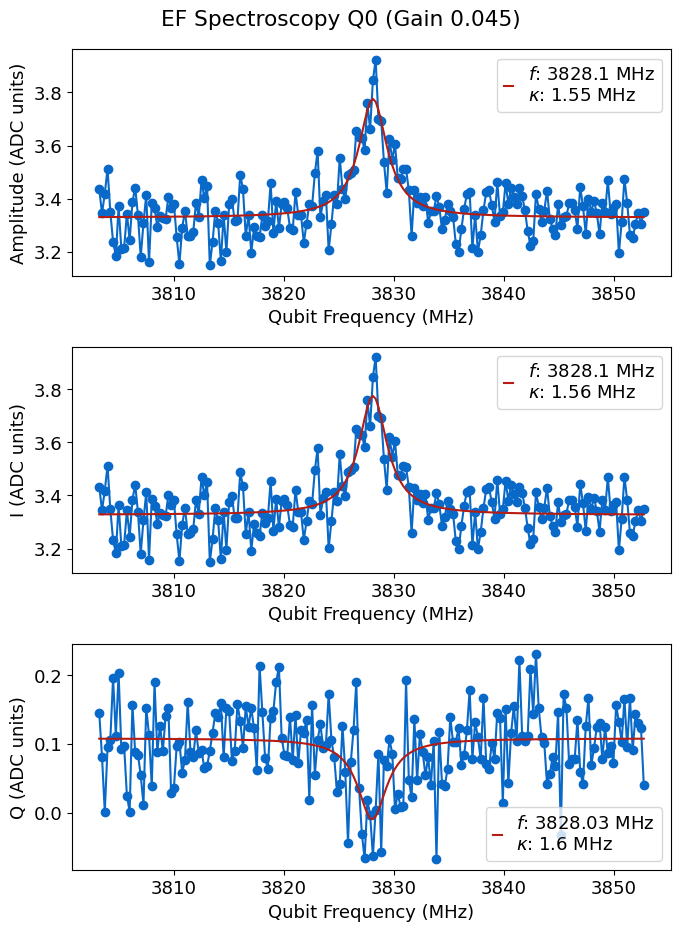

*Set cfg device.qubit 0 f_ef to 3828.0993 from 3827.9693*
Performing fine scan


  0%|          | 0/200000 [00:00<?, ?it/s]

R2:0.843	Fit par error:0.036	 Best fit:b'avgi'


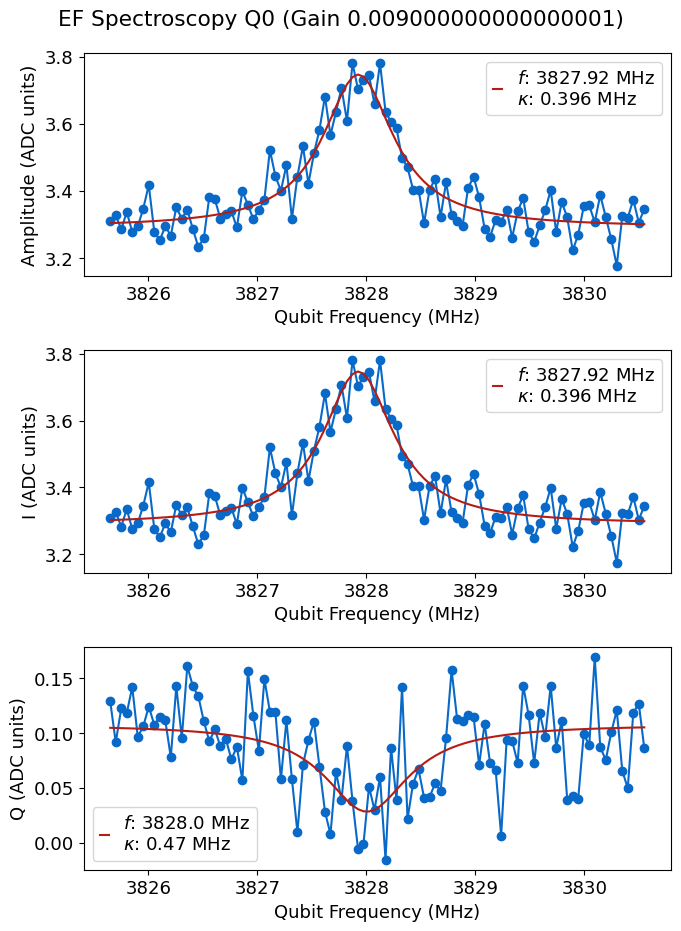

*Set cfg device.qubit 0 f_ef to 3827.9248 from 3828.0993*
Found qubit 0


In [242]:
#qubit_list= np.arange(1,20)
qubit_list=[0]

bad_qubits=[]

for qi in qubit_list:
    status, ntries = qubit_tuning.find_spec(qi, cfg_dict, start='medium', freq='ef')
    if not status:
        bad_qubits.append(qi)

### Specific width

  0%|          | 0/2000000 [00:00<?, ?it/s]

R2:0.558	Fit par error:0.052	 Best fit:b'amps'


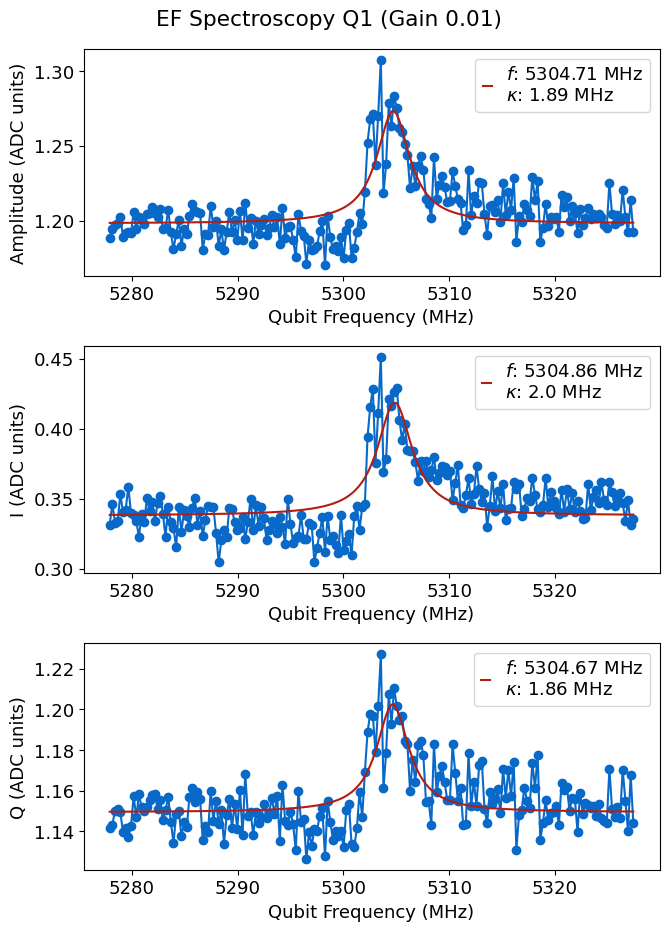

In [283]:
# You may want to update this frequency, which will be the center of the scan. 
#style huge, coarse, medium, fine 
update=False

qubit_list = np.arange(10)
qubit_list=[1]
for qi in qubit_list:
    qspec=meas.QubitSpec(cfg_dict, qi=qi, style='medium', params={'checkEF':True, 'gain':0.01})#, params={'span':500, 'expts':1000,'reps':500,'gain':0.2})

    #qspec=meas.QubitSpec(cfg_dict, qi=qi, style='medium', params={'checkEF':True})#, params={'span':500, 'expts':1000,'reps':500,'gain':0.2})
    if update and qspec.status:
        auto_cfg = config.update_qubit(cfg_path, 'f_ef', qspec.data["best_fit"][2], qi)

## Rabi EF

  0%|          | 0/120000 [00:00<?, ?it/s]

R2:0.811	Fit par error:0.034	 Best fit:b'amps'


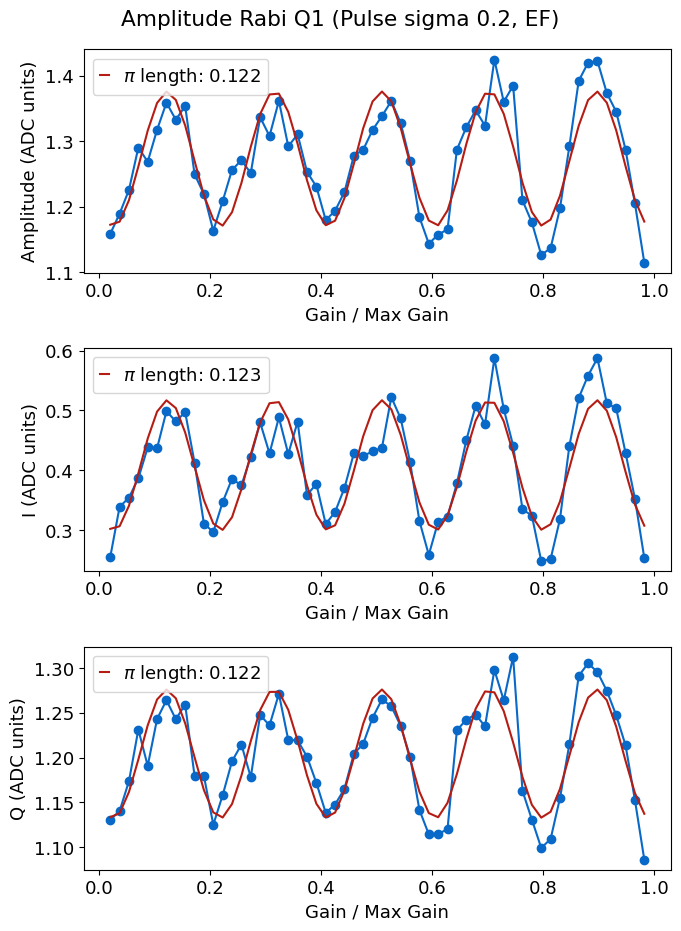

*Set cfg device.qubit 1 ('pulses', 'pi_ef', 'gain') to 0.1225 from 0.217*


In [279]:
# If first time, initialize the sigma and gain to those of the ge 
first_time =False
update = True

qubit_list = np.arange(1,20)
qubit_list=[1]

bad_qubits = []
auto_cfg = config.load(cfg_path)

for qi in qubit_list: 
    if first_time:
        #config.update_qubit(cfg_path, 'f_ef', auto_cfg.device.qubit.f_spec_ef[qi], qi)
        auto_cfg = config.update_qubit(cfg_path, ('pulses','pi_ef','sigma'), auto_cfg['device']['qubit']['pulses']['pi_ge']['sigma'][qi], qi)
        auto_cfg = config.update_qubit(cfg_path, ('pulses','pi_ef','gain'), auto_cfg['device']['qubit']['pulses']['pi_ge']['gain'][qi], qi)
    amp_rabi = meas.RabiExperiment(cfg_dict,qi=qi, params={'checkEF':True})
    if update and amp_rabi.status:
        config.update_qubit(cfg_path, ('pulses','pi_ef','gain'), amp_rabi.data['pi_length'], qi)
    else:
        print(f'Amplitude Rabi fit failed for qubit {qi}')
        bad_qubits.append(qi)

## Qubit Temperature

c:\_Lib\python\qq\slab_qick_calib\experiments\single_qubit\pulse_probe_spectroscopy.py:340: SyntaxWarning: invalid escape sequence '\k'
  {"index": 3, "format": "$\kappa$: {val:.3} MHz"},


  0%|          | 0/120000 [00:00<?, ?it/s]

R2:0.733	Fit par error:0.034	 Best fit:b'amps'


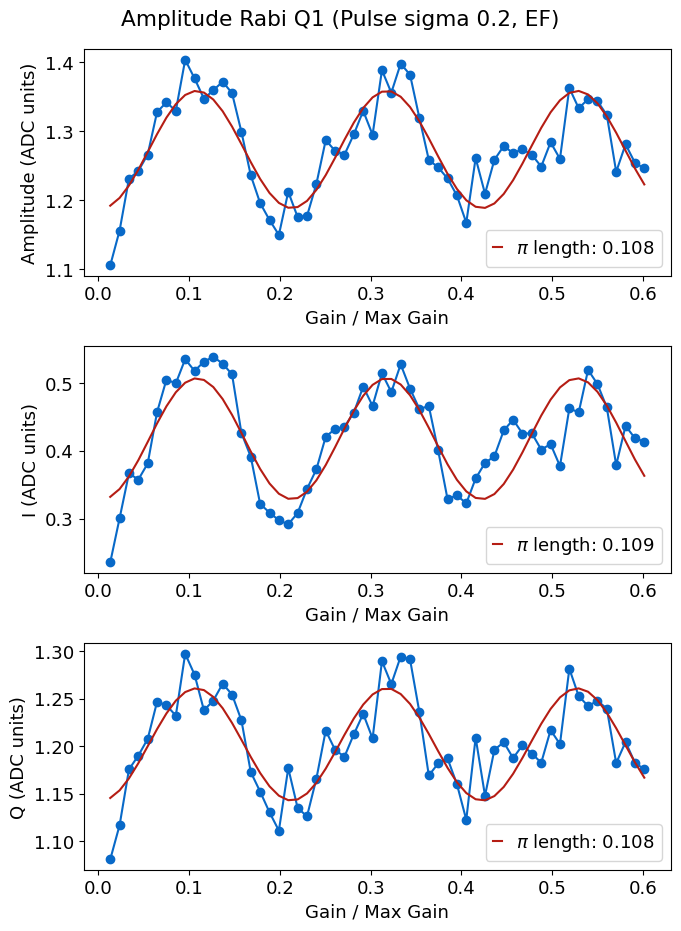

  0%|          | 0/20 [00:00<?, ?it/s]

R2:0.805	Fit par error:0.082	 Best fit:b'avgi'


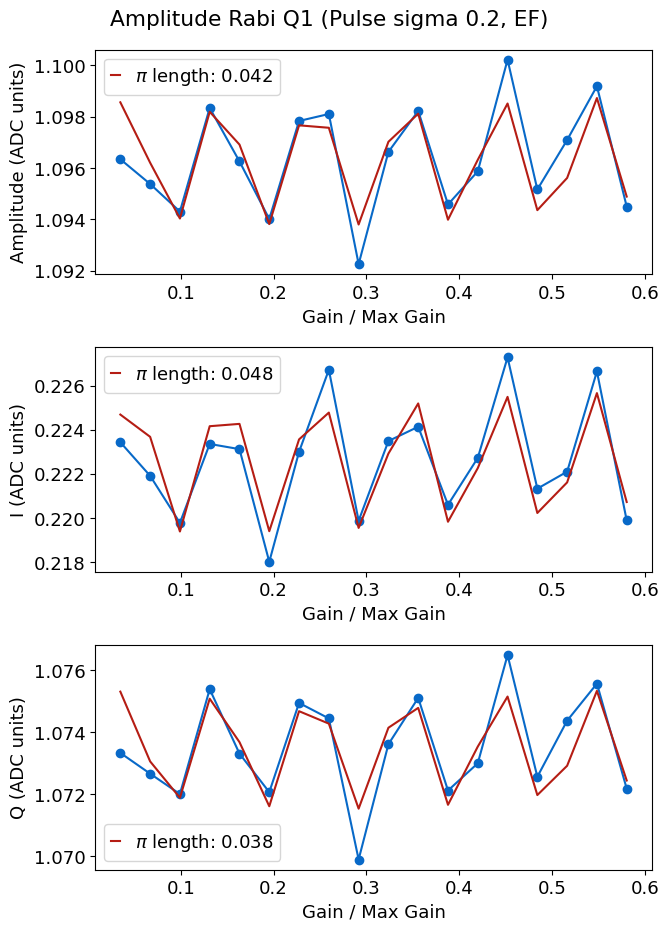

Qubit temp [mK]: 80.25676718007804
State preparation ratio: 0.03714858628091759
0.08491718494226096
0.003154553371560217


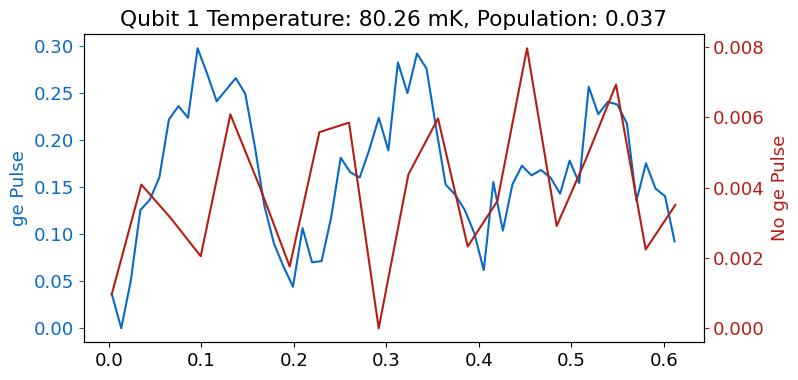

*Set cfg device.qubit 1 temp to 80.2568 from 0*
*Set cfg device.qubit 1 pop to 0.0371 from 0*


In [289]:
qubit_list = np.arange(1)
qubit_list=[1]
for qi in qubit_list: 
    # Soft_avgs will make scan take longer, needed for lower temperatures. 
    temp, pop = tuneup.measure_temp(cfg_dict, qi=qi)# , soft_avgs=5)
    auto_cfg = config.update_qubit(cfg_path, 'temp', temp, qi)
    auto_cfg = config.update_qubit(cfg_path, 'pop', pop, qi)

## Ramsey EF

  0%|          | 0/400000 [00:00<?, ?it/s]

R2:0.788	Fit par error:0.139	 Best fit:b'amps'


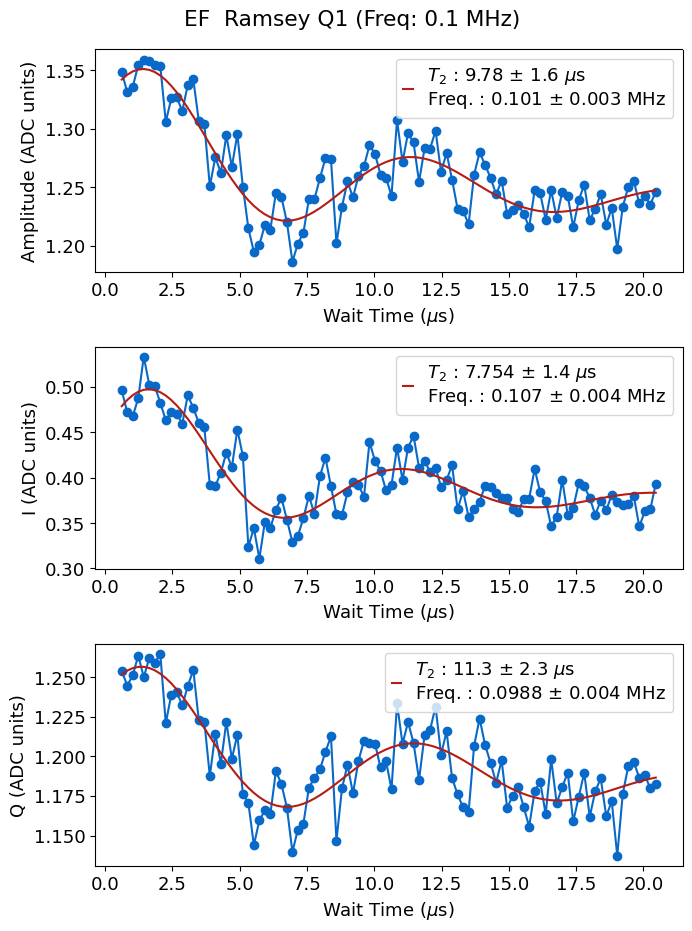

*Set cfg device.qubit 1 f_ef to 5302.662 from 5302.6627*


In [281]:
update=True
qubit_list=np.arange(1,20)
qubit_list=[1]

for qi in qubit_list:
    t2r = meas.T2Experiment(cfg_dict, qi=qi, params={'ramsey_freq':0.1, 'checkEF':True})

    if update and t2r.status:
        config.update_qubit(cfg_path, 'f_ef', t2r.data['new_freq'], qi)
    else:
        print('T2 Ramsey fit failed')

# Stark

## Ramsey

### Single experiment

In [ ]:
qi=0
meas.RamseyStarkExperiment(cfg_dict, qi=qi, params={'stark_gain':0.0,'step':0.1,'df':200,'acStark':True,'ramsey_freq':0.1})

### Sweep frequency

In [ ]:
qubit_list = np.arange(3,20)
qubit_list=[0]
gain = np.linspace(0.1,1,10)
for qi in qubit_list:
    for g in gain:
        t2rstark=meas.RamseyStarkFreqExperiment(cfg_dict, qi=qi, params={'step':1/430+0.001, 'stark_gain':g, 'start_df':30, 'end_df':150, 'expts_df':10})

In [ ]:
qubit_list = np.arange(3,20)
qubit_list=[17]
for qi in qubit_list:
    t2rstark=meas.RamseyStarkFreqExperiment(cfg_dict, qi=qi, params={'step':1/430+0.001, 'stark_gain':0.1, 'start_df':20, 'end_df':100, 'expts_df':40})

### Calibrate stark power positive freq

c:\_Lib\python\qq\slab_qick_calib\experiments\single_qubit\t2_ramsey_stark.py:115: SyntaxWarning: invalid escape sequence '\m'
  xlabel = "Wait Time ($\mu$s)"
c:\_Lib\python\qq\slab_qick_calib\experiments\single_qubit\t2_ramsey_stark.py:120: SyntaxWarning: invalid escape sequence '\p'
  {"index": 3, "format": "$T_2$ Ramsey : {val:.4} $\pm$ {err:.2g} $\mu$s"},
c:\_Lib\python\qq\slab_qick_calib\experiments\single_qubit\t2_ramsey_stark.py:121: SyntaxWarning: invalid escape sequence '\p'
  {"index": 1, "format": "Freq. : {val:.3} $\pm$ {err:.1} MHz"},
c:\_Lib\python\qq\slab_qick_calib\experiments\single_qubit\t2_ramsey_stark.py:226: SyntaxWarning: invalid escape sequence '\m'
  xlabel = "Wait Time ($\mu$s)"
c:\_Lib\python\qq\slab_qick_calib\experiments\single_qubit\t2_ramsey_stark.py:346: SyntaxWarning: invalid escape sequence '\m'
  xlabel = "Wait Time ($\mu$s)"


Unexpected parameters found in params: {'stark_freq', 'start_gain', 'expts_gain', 'end_gain'}


  0%|          | 0/12 [00:00<?, ?it/s]

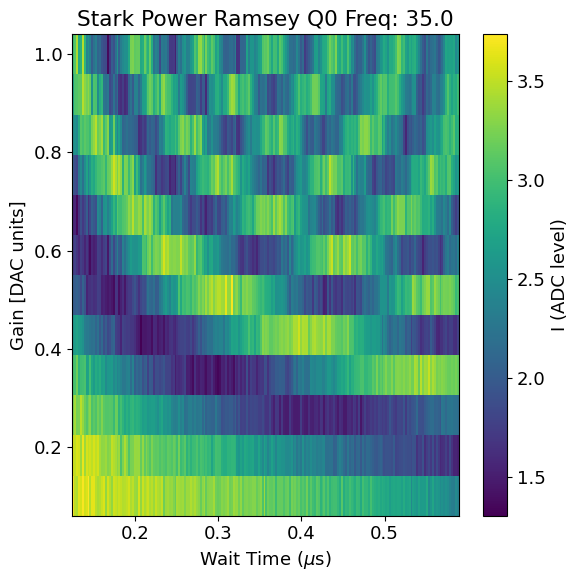

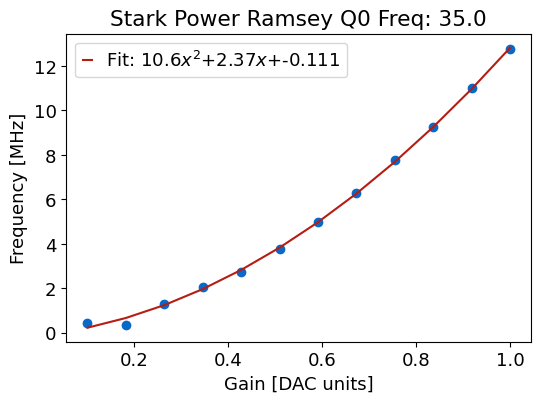

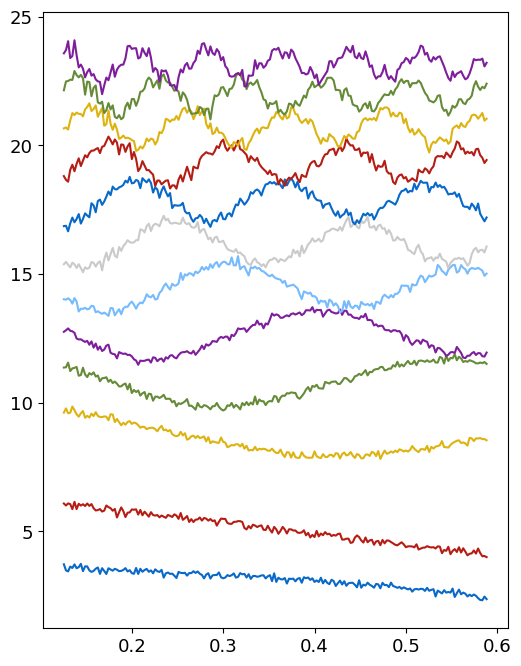

In [296]:
qubit_list = np.arange(13,20)
qubit_list=[0]
d=[]
freqs= [35]
for f in freqs:
    for qi in qubit_list:
        t2rstark=meas.RamseyStarkPowerExperiment(cfg_dict, qi=qi, params={'step':1/430+0.001, 'expts_gain':12, 'df':f, 'start_gain':0.1, 'end_gain':1})
        d.append(t2rstark)
        # config.update_stark(cfg_path, 'q', t2rstark.data['quad_fit'][0], qi)
        # config.update_stark(cfg_path, 'l', t2rstark.data['quad_fit'][1], qi)
        # config.update_stark(cfg_path, 'o', t2rstark.data['quad_fit'][2], qi)

In [ ]:
plt.figure()
for i in range(len(t2rstark.data['bin_centers'])):
    plt.plot(t2rstark.data['bin_centers'][i], t2rstark.data['hist'][i])

### Negative frequency

In [ ]:
#qubit_list = np.arange(20)
d=[]
qubit_list=[19]
for qi in qubit_list:
    t2rstark=meas.RamseyStarkPowerExperiment(cfg_dict, qi=qi, params={'step':1/430+0.001, 'expts_gain':12, 'df':-100, 'start_gain':0.08, 'end_gain':0.35, 'soft_avgs':2})
    d.append(t2rstark)
    config.update_stark(cfg_path, 'qneg', t2rstark.data['quad_fit'][0], qi)
    config.update_stark(cfg_path, 'lneg', t2rstark.data['quad_fit'][1], qi)
    config.update_stark(cfg_path, 'oneg', t2rstark.data['quad_fit'][2], qi)
#handy.plot_many(d, title='Ramsey Stark', save_path=cfg_dict['expt_path'])

## T1

### Single exp

In [ ]:
qi=19
gain_list = [0.5,0.6,0.77]
for g in gain_list:
    t1 = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':g,'expts':300,'span':10}) 

In [ ]:
plt.figure()

t1 = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.2,'end_wait':10}) 
t12 = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.7,'end_wait':10}) 
t1x = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.2,'end_wait':5}) 
t1y = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.7,'end_wait':5}) 
t13 = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.2,'end_wait':0.05}) 
t14 = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.7, 'end_wait':0.05}) 

plt.plot(t1.data['bin_centers'], t1.data['hist'], 'r')
plt.plot(t12.data['bin_centers'], t12.data['hist'],'r')

plt.plot(t1x.data['bin_centers'], t12.data['hist'],'g')
plt.plot(t1y.data['bin_centers'], t12.data['hist'],'g')

plt.plot(t13.data['bin_centers'], t13.data['hist'],'b')
plt.plot(t14.data['bin_centers'], t14.data['hist'],'b')

In [ ]:
plt.figure()

t1 = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.2}) 
t12 = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.7}) 
plt.plot(t1.data['bin_centers'], t1.data['hist'])
plt.plot(t12.data['bin_centers'], t12.data['hist'])

### Gain sweep

Unexpected parameters found in params: {'stark_freq', 'end_gain', 'start_gain', 'expts_gain'}


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

c:\_Lib\python\qq\slab_qick_calib\..\slab_qick_calib\fitting.py:153: OptimizeWarning: Covariance of the parameters could not be estimated
  pOpt, pCov = sp.optimize.curve_fit(fitfunc, xdata, ydata, p0=fitparams)


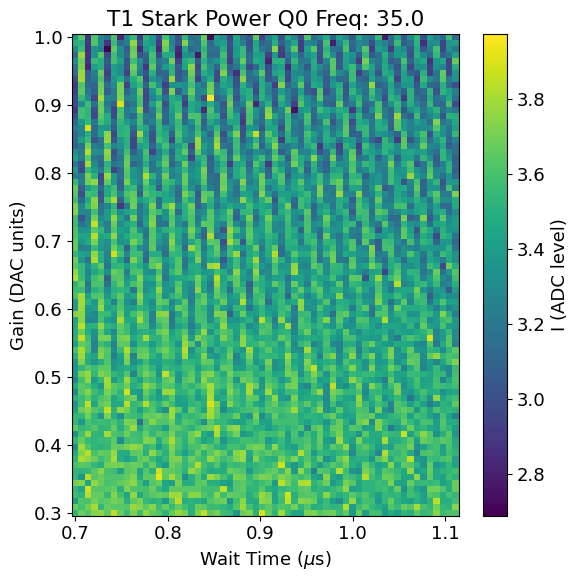

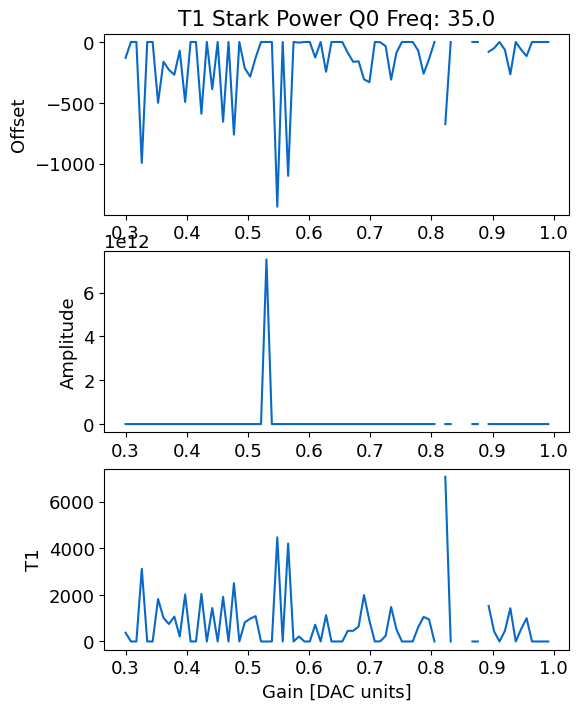

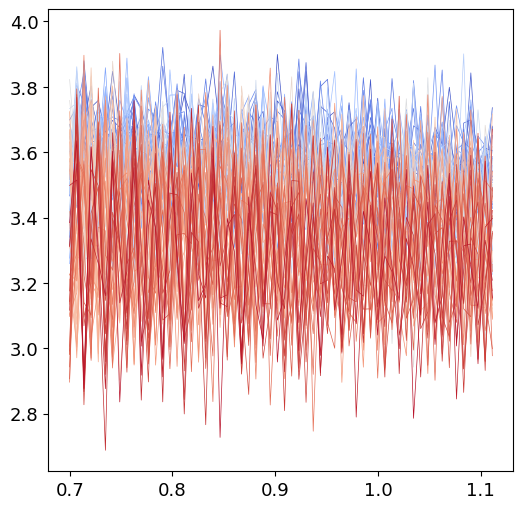

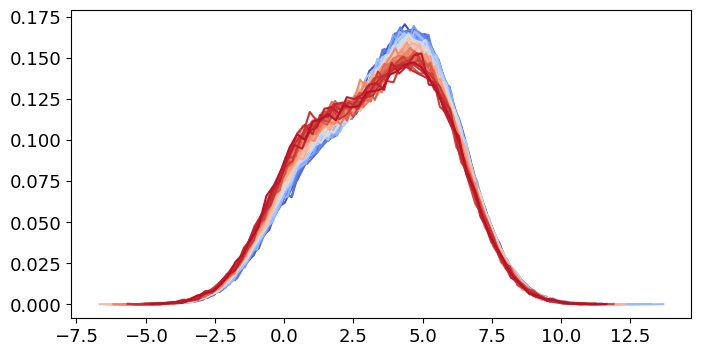

In [297]:
qubit_list = np.arange(12,20)
qubit_list=[0]
flist=[35]
for f in flist:
    for qi in qubit_list: 
        #t1_neg = meas.T1StarkPowerExperiment(cfg_dict, qi=qi, params={'df':-70,'start_gain':0.02,'end_gain':0.2,'start':3, 'soft_avgs':4})

        t1_pos = meas.T1StarkPowerExperiment(cfg_dict, qi=qi, params={'df':f,'start_gain':0.3,'end_gain':1,'start':0.2, 'soft_avgs':1,'span':0.5,'expts_gain':80}) #, 'start':100,'span':0.34, 'expts':100, 'soft_avgs':3})
        plt.figure()
        for i in range(len(t1_pos.data['bin_centers'])):
            plt.plot(t1_pos.data['bin_centers'][i], t1_pos.data['hist'][i])

### Freq sweep

In [ ]:
t1_freq = meas.T1StarkFreqExperiment(cfg_dict, qi=19, params={'span':6, 'span_f':100, 'start_df':50, 'expts_f':100})

In [ ]:
t1_freq = meas.T1StarkFreqExperiment(cfg_dict, qi=19, params={'span':6, 'span_f':100, 'start_df':50, 'expts_f':100,'gain':0.5})

### Single evo point linear gain sweep

c:\_Lib\python\qq\slab_qick_calib\experiments\single_qubit\t1_stark.py:186: SyntaxWarning: invalid escape sequence '\m'
  xlabel = "Wait Time ($\mu$s)"
c:\_Lib\python\qq\slab_qick_calib\experiments\single_qubit\t1_stark.py:190: SyntaxWarning: invalid escape sequence '\p'
  {"index": 2, "format": "$T_1$ fit: {val:.3} $\pm$ {err:.2} $\mu$s"},
c:\_Lib\python\qq\slab_qick_calib\experiments\single_qubit\t1_stark.py:292: SyntaxWarning: invalid escape sequence '\m'
  super().display(plot_both=plot_both, title=title, xlabel=xlabel, ylabel=ylabel)
c:\_Lib\python\qq\slab_qick_calib\experiments\single_qubit\t1_stark.py:404: SyntaxWarning: invalid escape sequence '\m'
  
c:\_Lib\python\qq\slab_qick_calib\experiments\single_qubit\t1_stark.py:533: SyntaxWarning: invalid escape sequence '\m'
  ax = ax.flatten()
c:\_Lib\python\qq\slab_qick_calib\experiments\single_qubit\t1_stark.py:653: SyntaxWarning: invalid escape sequence '\m'
  #ax = ax.flatten()
c:\_Lib\python\qq\slab_qick_calib\experiments\singl

Unexpected parameters found in params: {'stark_freq'}


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

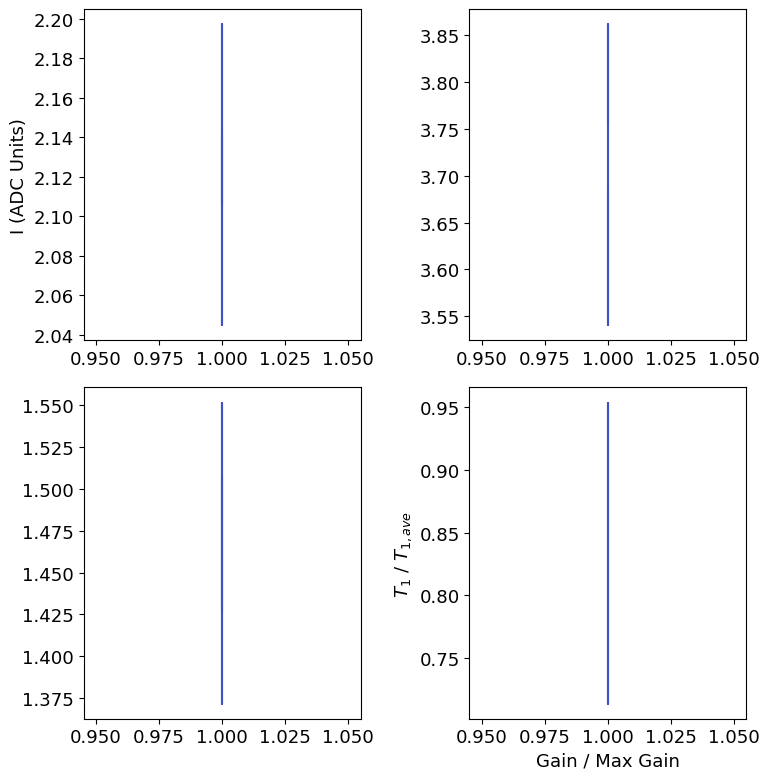

In [299]:
t1_cont = meas.T1StarkPowerSingle(cfg_dict, qi=0, params={"soft_avgs":4})

### Run linear scan for multiple qubits

In [ ]:
#first, need to configure active reset and check stark for all. 
nexp = 3
qubit_list =[1,2]#2,4,5,6,7]
expts = 200
t1_data = [[] for _ in qubit_list]

for i in range(nexp):
    for j, qi in enumerate(qubit_list):
        t1_cont = meas.T1StarkPowerSingle(cfg_dict, qi=qi, params={ "soft_avgs":2,'expts':100})
        t1_data[j].append(t1_cont.data['t1'])

plt.figure()
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
ax = ax.flatten()
for i, qi in enumerate(qubit_list):
    ax[i].set_title(f'Q{qi}')
    ax[i].pcolormesh(t1_data[i])
    plt.colorbar(ax[i].collections[0], ax=ax[i])

### Repeated single evo, sweep frequency linearly with gain [Main scan]

In [ ]:
d=[]
qi=6
params={'stop_f':20, 'df_pos':100, 'df_neg':-70}
for i in range(200):
    if i%10==0:
        t1stark=meas.T1StarkPowerQuadSingle(cfg_dict, qi=qi, params=params)
        shot = meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':20000})
        config.update_readout(cfg_path, 'threshold',shot.data['thresholds'][0], qi);
        config.update_readout(cfg_path, 'phase', shot.data['angle'], qi);
        phase.append(shot.data['angle'])
    else:
        t1stark=meas.T1StarkPowerQuadSingle(cfg_dict, qi=qi, params=params, display=False, progress=False)

    d.append(t1stark)

times = [d[i].data['start_time'] for i in range(0, len(d))] 
tm = [datetime.strptime(times[i].decode('utf-8'), '%Y-%m-%d %H:%M:%S') for i in range(len(times))]
time_from_first = [(t - tm[0]).total_seconds() for t in tm]
print(time_from_first)

concatenated_data = np.concatenate([d[i].data['avgi'] for i in range(0, len(d))], axis=1)

plt.figure()
plt.pcolormesh(concatenated_data)

In [ ]:
plt.figure()
concatenated_data = np.concatenate([d[i].data['avgi'] for i in range(0, len(d))], axis=1)
import matplotlib.dates as mdates

plt.pcolormesh(np.array(time_from_first)/60/60, d[-1].data['f_pts'], concatenated_data)
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
#plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
#plt.gcf().autofmt_xdate()


### Calib sweep

### Analysis of multiple evo times using normal fittingh

In [ ]:
# Processing for multiple evo times 
cd0 = np.concatenate([d[i].data['avgi_0'] for i in range(0, len(d))], axis=1)
cd1 = np.concatenate([d[i].data['avgi_1'] for i in range(0, len(d))], axis=1)
cd2 = np.concatenate([d[i].data['avgi_2'] for i in range(0, len(d))], axis=1)
cd3 = np.concatenate([d[i].data['avgi_3'] for i in range(0, len(d))], axis=1)

combined_cd = np.stack((cd0, cd1, cd2, cd3), axis=-1)
print(combined_cd.shape)

tms=d[0].data['wait_times']

sns.set_palette('coolwarm',len(combined_cd))
from scipy.optimize import curve_fit
plt.figure()
def t1_fit(x, a, b, c):
    return b * np.exp(-x / c) + a
fits=[]
tm_full = np.linspace(0, tms[3])
#for i in range(5):
for i in range(len(combined_cd)):
    plt.plot(tms, combined_cd[i][0][:],'o-')
    p0 = (np.min(combined_cd[i][0][:]), np.max(combined_cd[i][0][:])-np.min(combined_cd[i][0][:]), tms[2])
    popt, err = curve_fit(t1_fit, tms, combined_cd[i][0][:], p0=p0)
    fit_err = np.sqrt(np.diag(err))   
    if np.mean(fit_err/np.abs(popt))>0.5:
        fits.append(np.nan*np.ones(3))   
    else:
        fits.append(popt)
    #print(p0)
    #plt.plot(tm_full, t1_fit(np.array(tm_full), *popt),'k', label=f'Fit {i}')
    #print(popt)
#plt.legend()
t1_data = [fits[i][2] for i in range(len(fits))]    
offset = [fits[i][0] for i in range(len(fits))]
amp = [fits[i][1] for i in range(len(fits))]

fig, ax = plt.subplots(3, 1, figsize=(8, 7))
ax[0].plot(t1_data, 'o-')
ax[1].plot(offset, 'o-')
ax[2].plot(amp, 'o-')

In [ ]:
# Concatenate all d[i].data['avgi'] into a single dataset
concatenated_data = np.concatenate([d[i].data['avgi'] for i in range(1, len(d))], axis=1)

#print(concatenated_data)

plt.figure()
plt.pcolormesh(concatenated_data)

#### Check max value for calibration

In [ ]:
np.max(t1.data['avgi'], axis=1)
plt.figure()
plt.plot(np.max(t1.data['avgi'], axis=1))